# References:
1. https://www.kaggle.com/hely333/eda-regression
2. http://rstudio-pubs-static.s3.amazonaws.com/142772_218508e3f94e4419944e9104505b6f17.html
3. http://blog.kaggle.com/2016/01/22/rossmann-store-sales-winners-interview-3rd-place-cheng-gui/
4. https://www.kaggle.com/c/rossmann-store-sales/discussion/17974
5. https://jikeme.com/rossmann-store-sales-winners-interview-3rd-place-neokami-inc
6. https://github.com/li-kai/rossman-store-sales/blob/master/hw3-rossman.ipynb
7. http://blog.kaggle.com/2015/12/21/rossmann-store-sales-winners-interview-1st-place-gert/
8. http://cs229.stanford.edu/proj2015/218_report.pdf
9. http://rohanrao91.blogspot.com/2015/12/rossmann-store-sales.html
10. https://mabrek.github.io/blog/kaggle-forecasting/
11. https://arxiv.org/pdf/1604.06737.pdf
12. http://www.johnatate.com/learning-from-the-best-rossman-sales-kaggle-winners.html
13. https://www.kaggle.com/abhilashawasthi/xgb-rossmann
14. https://www.kaggle.com/c/rossmann-store-sales/discussion/18024
15. https://rpubs.com/gpetho/142772

# Dataset
1. https://www.kaggle.com/marcinex1423/salesdb-grocery#salesDB_grocery_market.zip
1. https://www.kaggle.com/fayomi/advertising
2. https://www.kaggle.com/harlfoxem/housesalesprediction
3. https://github.com/awesomedata/awesome-public-datasets
4. https://www.kdnuggets.com/datasets/index.html
5. https://www.kaggle.com/devashish0507/big-mart-sales-prediction
6. https://archive.ics.uci.edu/ml/datasets/Statlog+(Vehicle+Silhouettes)

# 0.0 IMPORTS
---

In [2]:
import pandas                                                 as pd
import seaborn                                                as sns
import xgboost                                                as xgb
import warnings                               
import statsmodels.api                                        as sm
import statsmodels.formula.api                                as smf

from time                      import time
from boruta                    import BorutaPy
from matplotlib                import pyplot                  as plt
from IPython.core.display      import HTML

from sklearn.svm               import SVR
from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing     import LabelEncoder, MinMaxScaler
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFECV

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [3]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def rmspe( y, yhat ):
    return np.sqrt( np.mean( ( yhat/y-1) **2 ) )


def rmspe_xg( yhat, y ):
    y = np.expm1( y.get_label() )
    yhat = np.expm1( yhat )
    return 'rmspe', rmspe( y, yhat )


def ml_error( model_name, y_test, yhat ):
    error = rmspe( y_test, yhat )
    mae = mean_absolute_error( y_test, yhat )
    rmse = np.sqrt( mean_squared_error( y_test, yhat ) )
    
    return pd.DataFrame( {'Model':model_name, 'RMSPE':error, 'RMSE':rmse, 'MAE':mae}, index=[0] )

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv( '../data/train.csv' )
df_stores_raw = pd.read_csv( '../data/store.csv' )

# Merge dataset
df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

# 1.0. DATA PREPARATION
---

In [6]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
101514,50,5,2015-05-01,0,0,0,1,a,0,d,a,6260.0,11.0,2009.0,0,NaN,NaN,NaN
126,127,5,2015-07-31,8560,848,1,1,0,0,d,a,1350.0,12.0,2005.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.1. Rename Attributes

In [7]:
df1 = df_raw.copy()

In [8]:
# new columns name
new_cols=['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
          'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']

# rename
df1.columns = new_cols

In [9]:
df1.sample(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
864482,28,5,2013-05-17,5335,648,1,1,0,1,a,a,1200.0,10.0,2014.0,1,6.0,2015.0,"Mar,Jun,Sept,Dec"
387097,226,3,2014-07-23,5662,621,1,0,0,0,a,a,450.0,NaN,NaN,0,NaN,NaN,NaN


# 2.0. DESCRIBE DATA
---

In [10]:
df2 = df1.copy()

## 2.1. Data Dimensions

In [11]:
print( 'Number of Rows: {}'.format( df2.shape[0] ) )
print( 'Number of Columns: {}'.format( df2.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 2.2. Data Type Attributes

In [12]:
df2.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# convert to datetime
df2['date'] = pd.to_datetime( df2['date'] )

df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 2.3. Number of NA

In [14]:
df2.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
store                           1017209 non-null int64
day_of_week                     1017209 non-null int64
date                            1017209 non-null datetime64[ns]
sales                           1017209 non-null int64
customers                       1017209 non-null int64
open                            1017209 non-null int64
promo                           1017209 non-null int64
state_holiday                   1017209 non-null object
school_holiday                  1017209 non-null int64
store_type                      1017209 non-null object
assortment                      1017209 non-null object
competition_distance            1014567 non-null float64
competition_open_since_month    693861 non-null float64
competition_open_since_year     693861 non-null float64
promo2                          1017209 non-null int64
promo2_since_week               509178 non-nul

## 2.4. Treat NA columns

In [16]:
df2.sample( 2 )

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
224469,355,7,2015-01-11,0,0,0,0,0,0,a,c,9720.0,8.0,2013.0,0,NaN,NaN,NaN
837482,903,2,2013-06-11,9519,684,1,0,0,0,d,c,7290.0,9.0,2014.0,0,NaN,NaN,NaN


In [17]:
# promo2_since_year
df2['promo2_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo2_since_week
df2['promo2_since_week'] = df2.apply( lambda x: x['date'].weekofyear if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# competition_distance
df2['competition_distance'] = df2['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month
df2['competition_open_since_month'] = df2.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 ) 

# competition_open_since_year
df2['competition_open_since_year'] = df2.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo_interval
## fill na with 0
df2.fillna( 0, inplace=True )
# if date is in the promo interval, there is promo.
monthmap = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df2['month_map'] = df2['date'].dt.month.map( monthmap )
df2['is_promo'] = df2[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [18]:
df2.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 2.5. Change the Columns Data Types

In [19]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
# change competition data - Month and Year
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype( int )
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype( int )

# change competition data - Week
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [21]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.6. Descriptive statistics

In [22]:
# separate the categorical from numerical features
num_attributes = df2.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df2.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df2.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 5
Num of Numerical: 14
Num of Date: 1


### 2.6.1. Central Tendency and Dispersion 

#### 2.6.1.1. Numerical Attributes

In [23]:
# Meausure of Central Tendency
ct1 = pd.DataFrame( num_attributes.apply( mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( median ) ).T


# Dispersion
d1 = pd.DataFrame( num_attributes.apply( std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T

m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'standard_deviation', 'kurtosis', 'skew']

m

,attributes,min,max,range,mean,median,standard_deviation,kurtosis,skew
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-0.000955
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,0.001593
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,0.641460
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,1.598650
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,-1.758045
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,0.487838
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,1.677842
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,10.242344
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-0.042076
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,-7.235657


### 2.6.1.2. Categorical Attributes

In [24]:
c = pd.DataFrame( cat_attributes.apply( lambda x: x.unique().shape[0], axis=0 ).reset_index() )
c.columns = ['Columns Names', 'Number of Levels']
print( c )

    Columns Names  Number of Levels
0   state_holiday                 5
1      store_type                 4
2      assortment                 3
3  promo_interval                 4
4       month_map                12


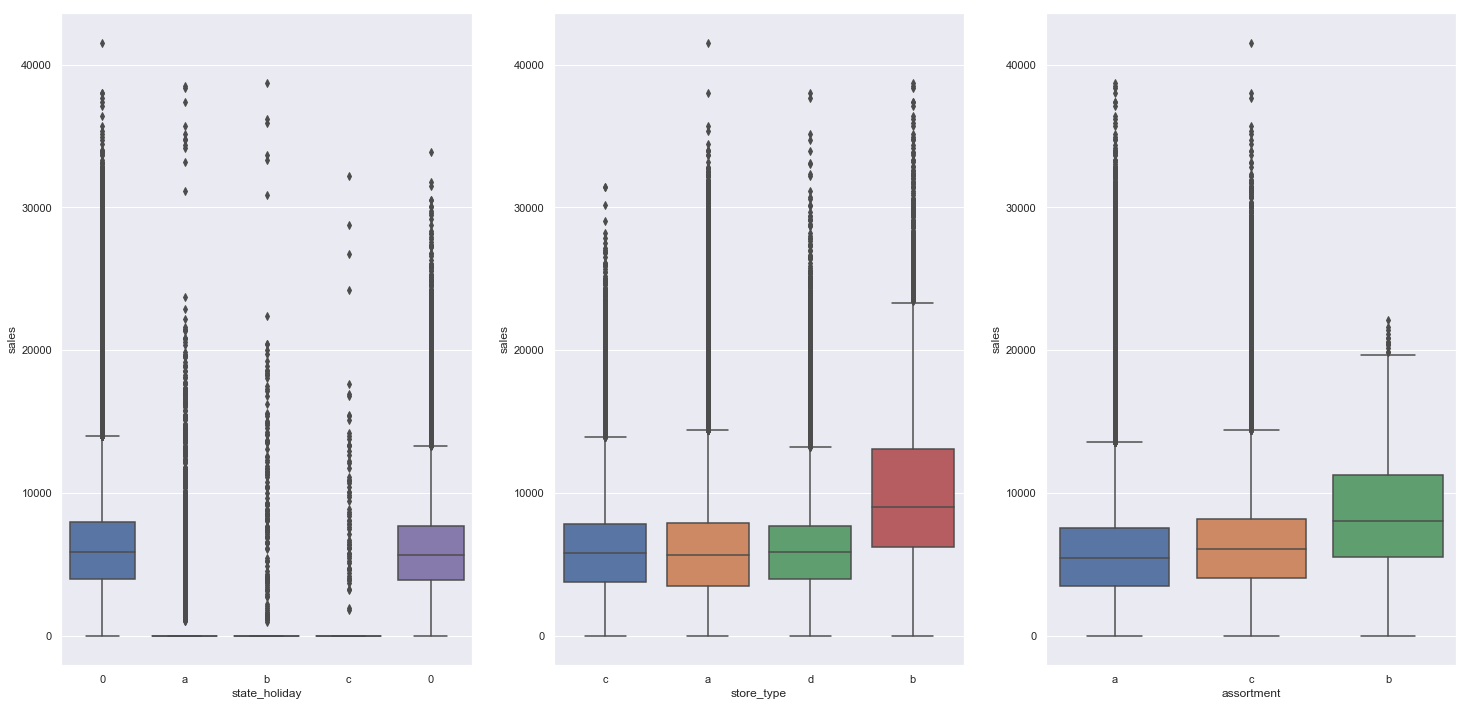

In [25]:
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=df2 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=df2 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=df2 );

# 3.0. FEATURE ENGINEERING
---

In [26]:
df3 = df2.copy()

## 3.1. Feature Creation

In [27]:
# year
df3['year'] = df3['date'].dt.year

# month
df3['month'] = df3['date'].dt.month

# day
df3['day'] = df3['date'].dt.day

# week of year
df3['week_of_year'] = df3['date'].dt.weekofyear

# state_holiday
df3['state_holiday'] = df3['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

# assortment
df3['assortment'] = df3['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# competition weeks
df3['month_of_competition'] = 12*( df3['year'] - df3['competition_open_since_year'] ) + ( df3['month'] - df3['competition_open_since_month'] )
df3['month_of_competition'] = df3['month_of_competition'].apply( lambda x: x if x > 0 else 0 )

# promomotion weeks
df3['month_of_promo'] = 12*( df3['year'] - df3['promo2_since_year'] ) + ( df3['week_of_year'] - df3['promo2_since_week'] )/4
df3['month_of_promo'] = df3['month_of_promo'].apply( lambda x: x if x > 0 else 0 )

# 4.0. SELECT FEATURES
---

In [28]:
df4 = df3.copy()

## 4.1. Filtering Rows

In [29]:
# only use data of Sales > 0 and Open is 1
df4 = df4[ (df4['open'] != 0) & (df4['sales'] > 0) ]

## 4.2. Selecting Columns

**Columns to Drop**
1. **date**: foram derivados novas features da variavel date
2. **customers**: voce nao sabe o numero de clientes no momento da predicao
3. **open**: todas as linhas sao open
4. **promo interval**: foram derivadas novas features
5. **month map**: variável auxiliar

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drop columns
df4 = df4.drop( cols_drop, axis=1 )

In [31]:
df4.head(3)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25


# 5.0. EXPLORATION DATA ANALYSIS 
---

In [32]:
df5 = df4.copy()

In [33]:
# separate the categorical from numerical features
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
dat_attributes = df5.select_dtypes( include=['datetime64[ns]'] )

print( 'Num of Categorical: {}'.format( cat_attributes.shape[1] ) )
print( 'Num of Numerical: {}'.format( num_attributes.shape[1] ) )
print( 'Num of Date: {}'.format( dat_attributes.shape[1] ) )

Num of Categorical: 3
Num of Numerical: 18
Num of Date: 1


## 5.1. Univariate Analysis

### 5.1.1. Response Variable

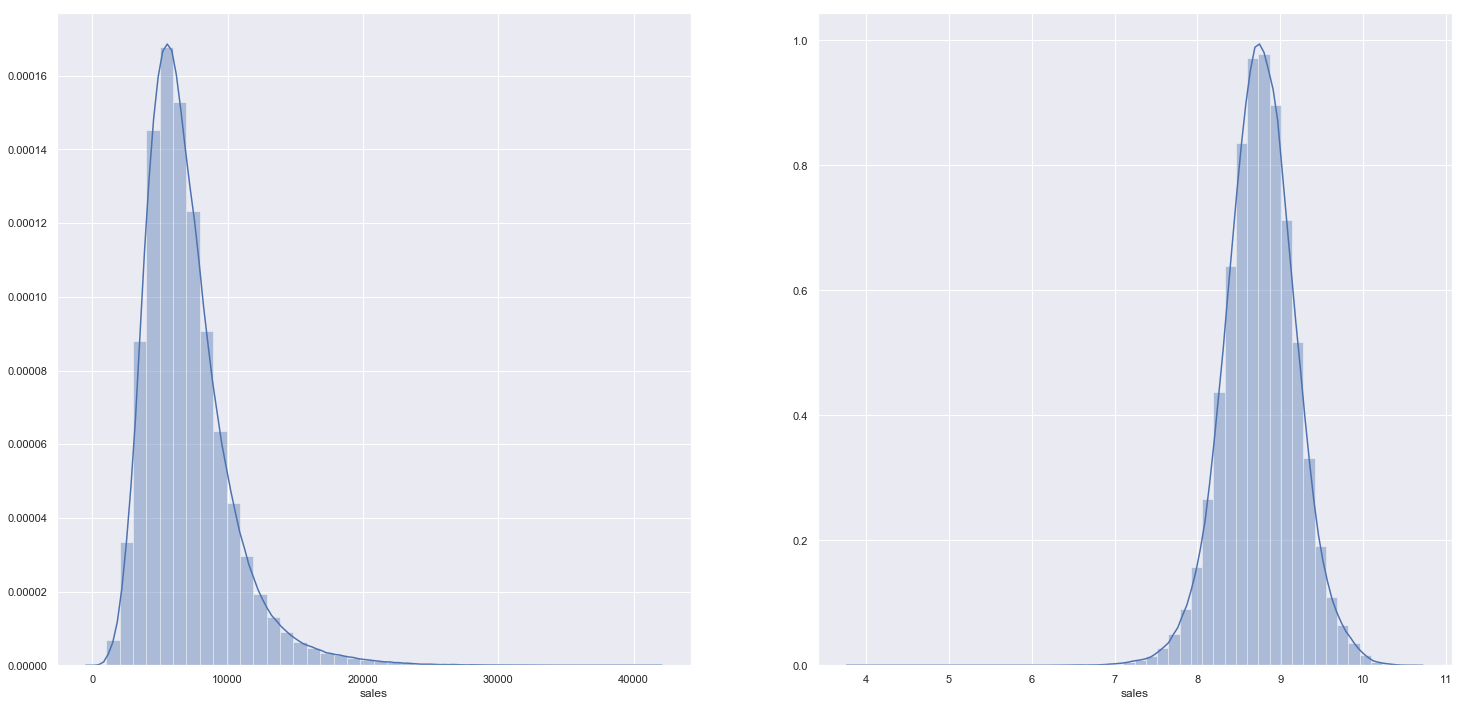

In [34]:
plt.subplot( 1, 2, 1 )
sns.distplot( df5['sales'], kde=True, bins=42 )

plt.subplot( 1, 2, 2 )
sns.distplot( np.log1p( df5['sales'] ), kde=True )

### 5.1.2. Numerical Predictors

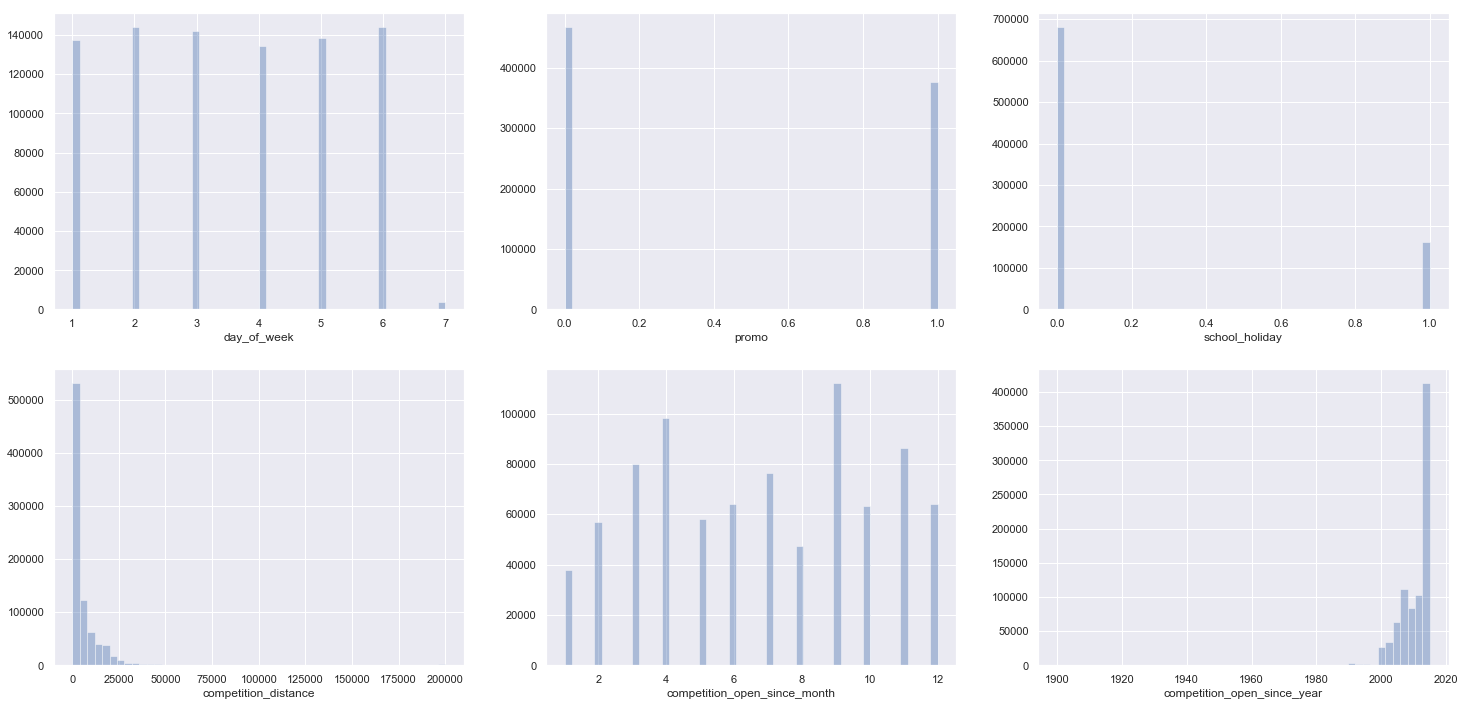

In [35]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['day_of_week'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['school_holiday'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['competition_distance'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['competition_open_since_month'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['competition_open_since_year'], kde=False );

In [36]:
num_attributes.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,month_of_competition,month_of_promo
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,82,0.00
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,92,64.50
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,103,52.25
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,70,0.00
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,3,0.00


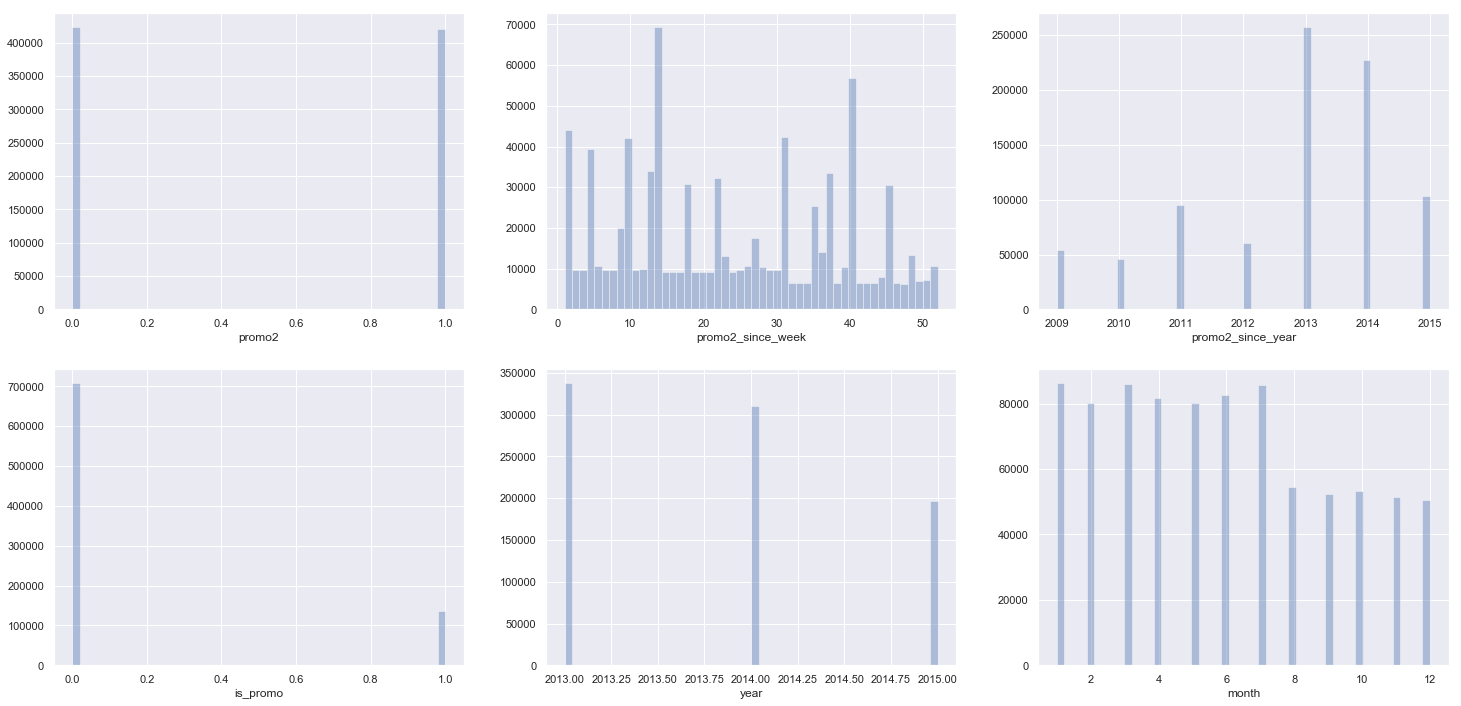

In [37]:
plt.subplot( 2, 3, 1 )
sns.distplot( df5['promo2'], kde=False );

plt.subplot( 2, 3, 2 )
sns.distplot( df5['promo2_since_week'], kde=False );

plt.subplot( 2, 3, 3 )
sns.distplot( df5['promo2_since_year'], kde=False );

plt.subplot( 2, 3, 4 )
sns.distplot( df5['is_promo'], kde=False );

plt.subplot( 2, 3, 5 )
sns.distplot( df5['year'], kde=False );

plt.subplot( 2, 3, 6 )
sns.distplot( df5['month'], kde=False );

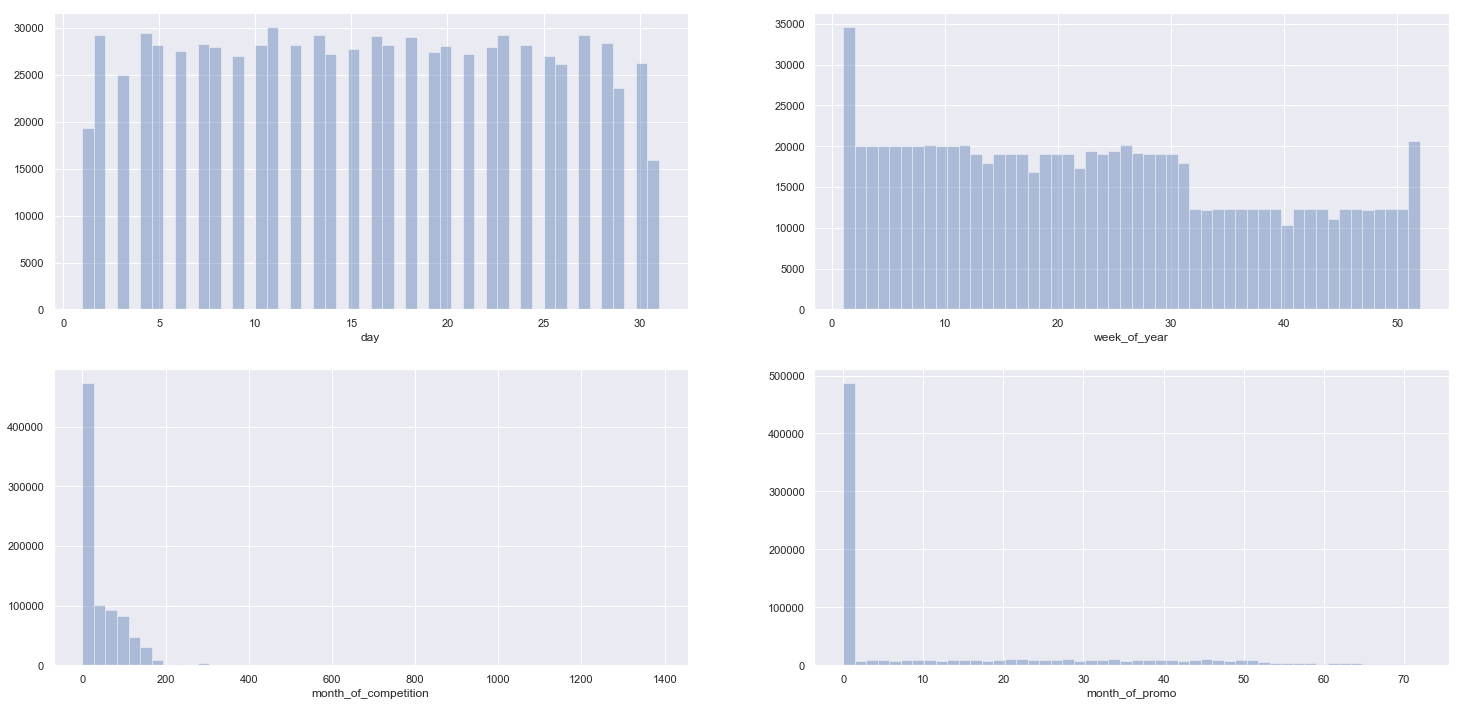

In [38]:
plt.subplot( 2, 2, 1 )
sns.distplot( df5['day'], kde=False );

plt.subplot( 2, 2, 2 )
sns.distplot( df5['week_of_year'], kde=False );

plt.subplot( 2, 2, 3 )
sns.distplot( df5['month_of_competition'], kde=False );

plt.subplot( 2, 2, 4 )
sns.distplot( df5['month_of_promo'], kde=False );

### 5.1.3. Categorical Predictors

In [39]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


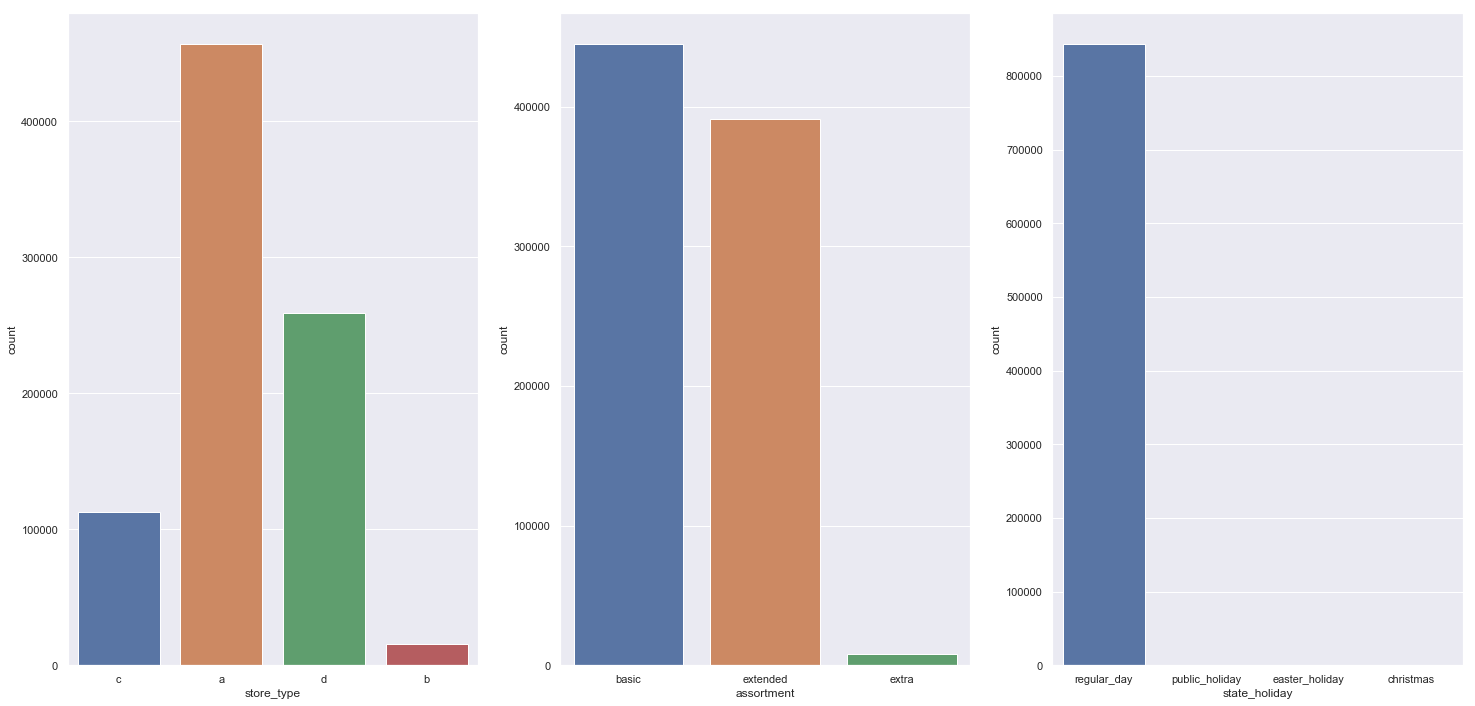

In [40]:
plt.subplot( 1, 3, 1 )
sns.countplot( x='store_type', data=df5 )

plt.subplot( 1, 3, 2 )
sns.countplot( x='assortment', data=df5 )

plt.subplot( 1, 3, 3 )
sns.countplot( x='state_holiday', data=df5 )

## 5.2. Bivariate Analysis

### 5.2.1. Numerical Predictors

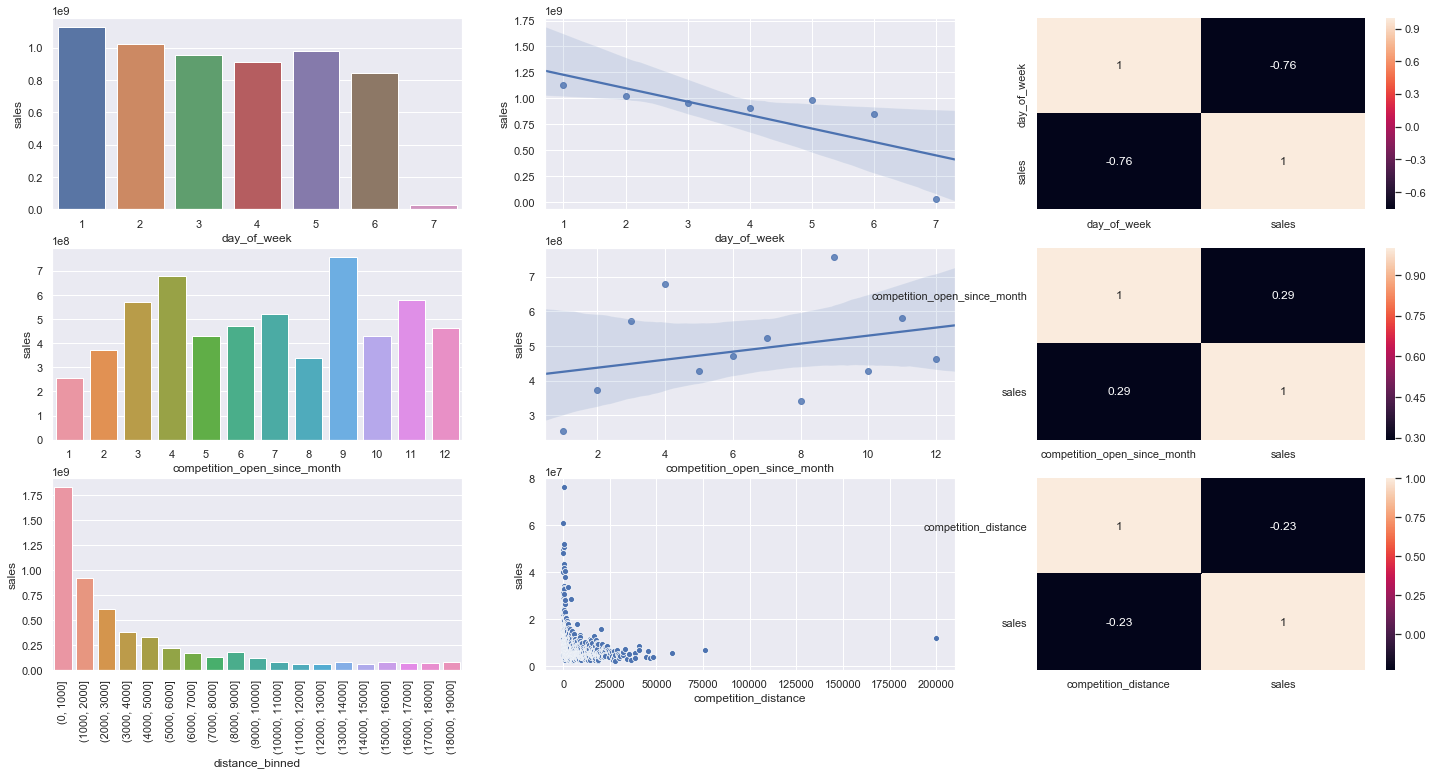

In [41]:
# -------------------
# day of week
# -------------------
aux1 = df5[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# ----------------------------
# competition open since month
# ----------------------------
aux3 = df5[['competition_open_since_month', 'sales']].groupby( 'competition_open_since_month' ).sum().reset_index()
cor3 = aux3.corr( method='pearson' )

plt.subplot( 3, 3, 4 )
sns.barplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='competition_open_since_month', y='sales', data=aux3 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor3, annot=True )

# -------------------
# competition distance
# -------------------
aux2 = df5[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
cor2 = aux2.corr( method='pearson' )

bins = list( np.arange( 0, 20000, 1000 ) )
aux2['distance_binned'] = pd.cut( aux2['competition_distance'], bins=bins )
aux3 = aux2[['distance_binned', 'sales']].groupby( 'distance_binned' ).sum().reset_index()

plt.subplot( 3, 3, 7 )
sns.barplot( x='distance_binned', y='sales', data=aux3 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 8 )
sns.scatterplot( x='competition_distance', y='sales', data=aux2 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor2, annot=True )


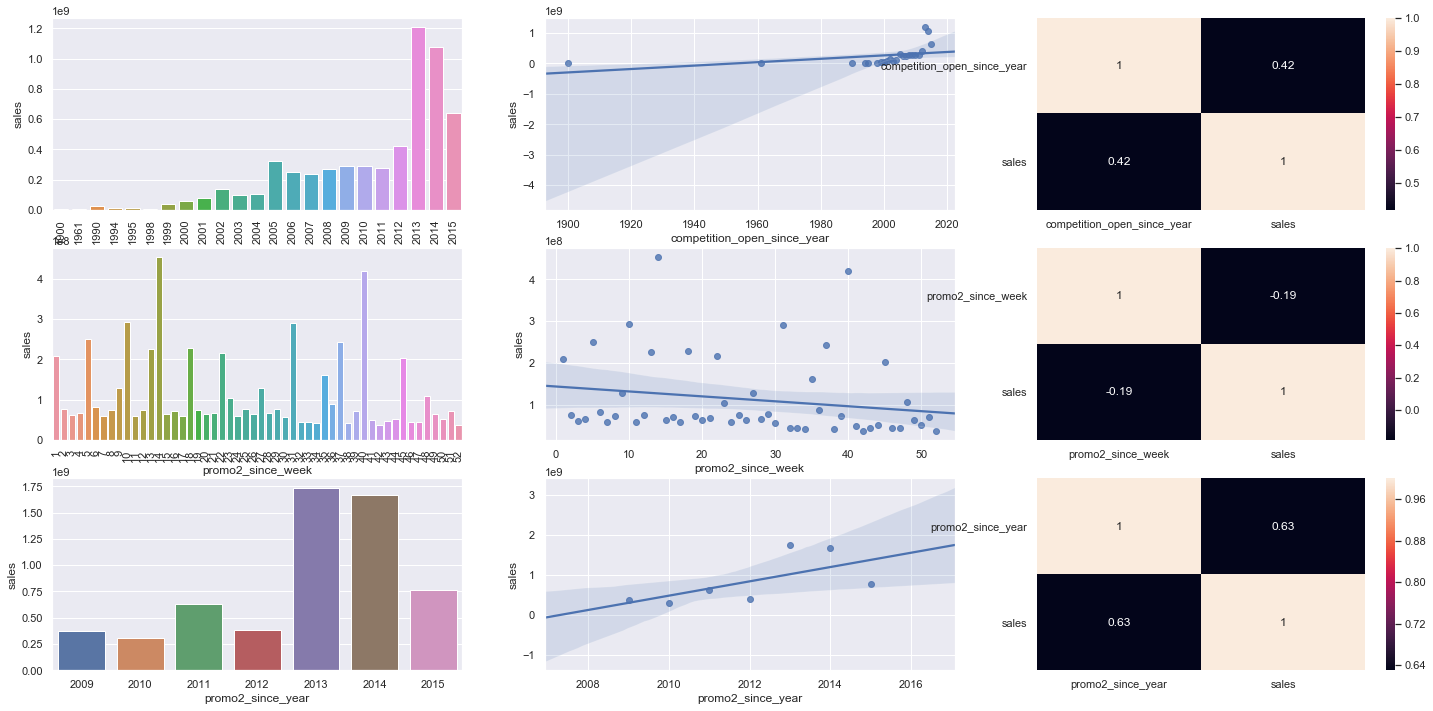

In [42]:
# ----------------------------
# competition open since year
# ----------------------------
aux1 = df5[['competition_open_since_year', 'sales']].groupby( 'competition_open_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='competition_open_since_year', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='competition_open_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since week
# -------------------
aux1 = df5[['promo2_since_week', 'sales']].groupby( 'promo2_since_week' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='promo2_since_week', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='promo2_since_week', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# promo2 since year
# -------------------
aux1 = df5[['promo2_since_year', 'sales']].groupby( 'promo2_since_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='promo2_since_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


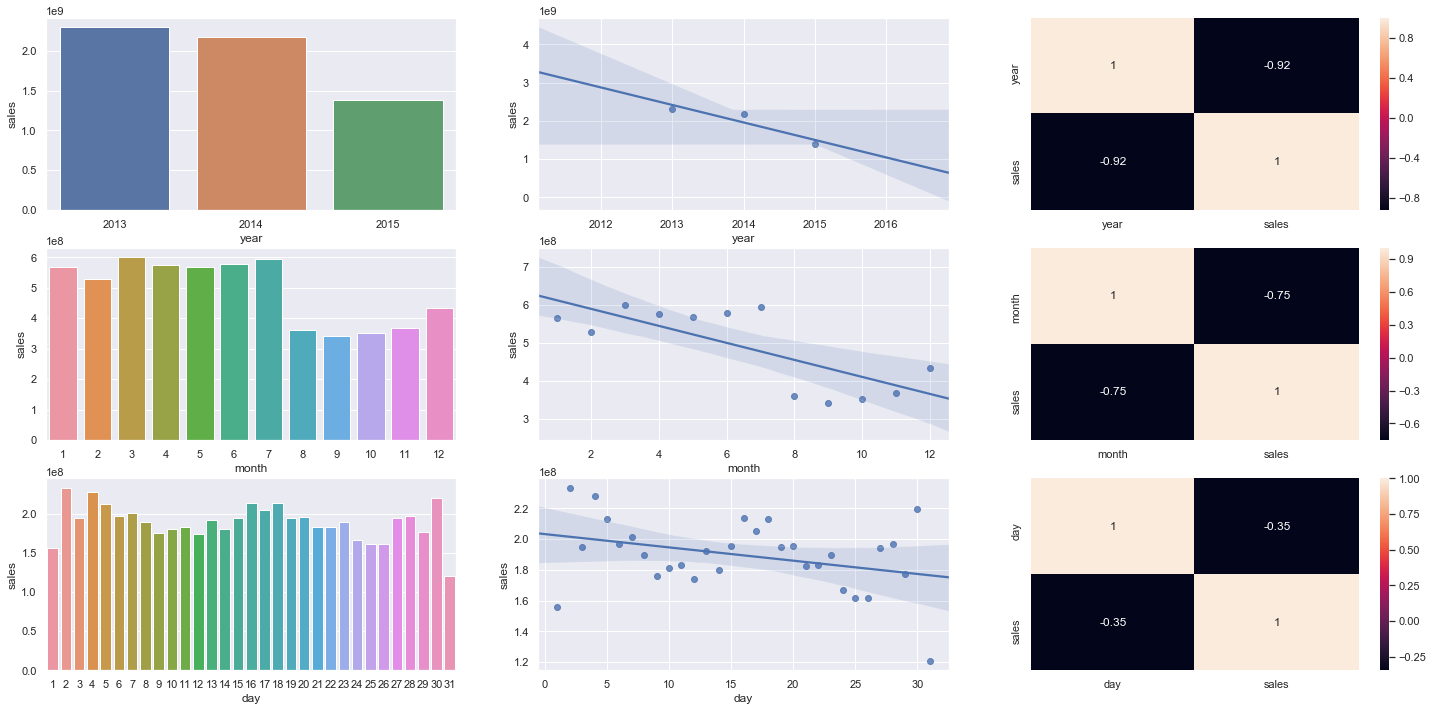

In [43]:
# ----------------------------
# year
# ----------------------------
aux1 = df5[['year', 'sales']].groupby( 'year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month
# -------------------
aux1 = df5[['month', 'sales']].groupby( 'month' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# day
# -------------------
aux1 = df5[['day', 'sales']].groupby( 'day' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='day', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


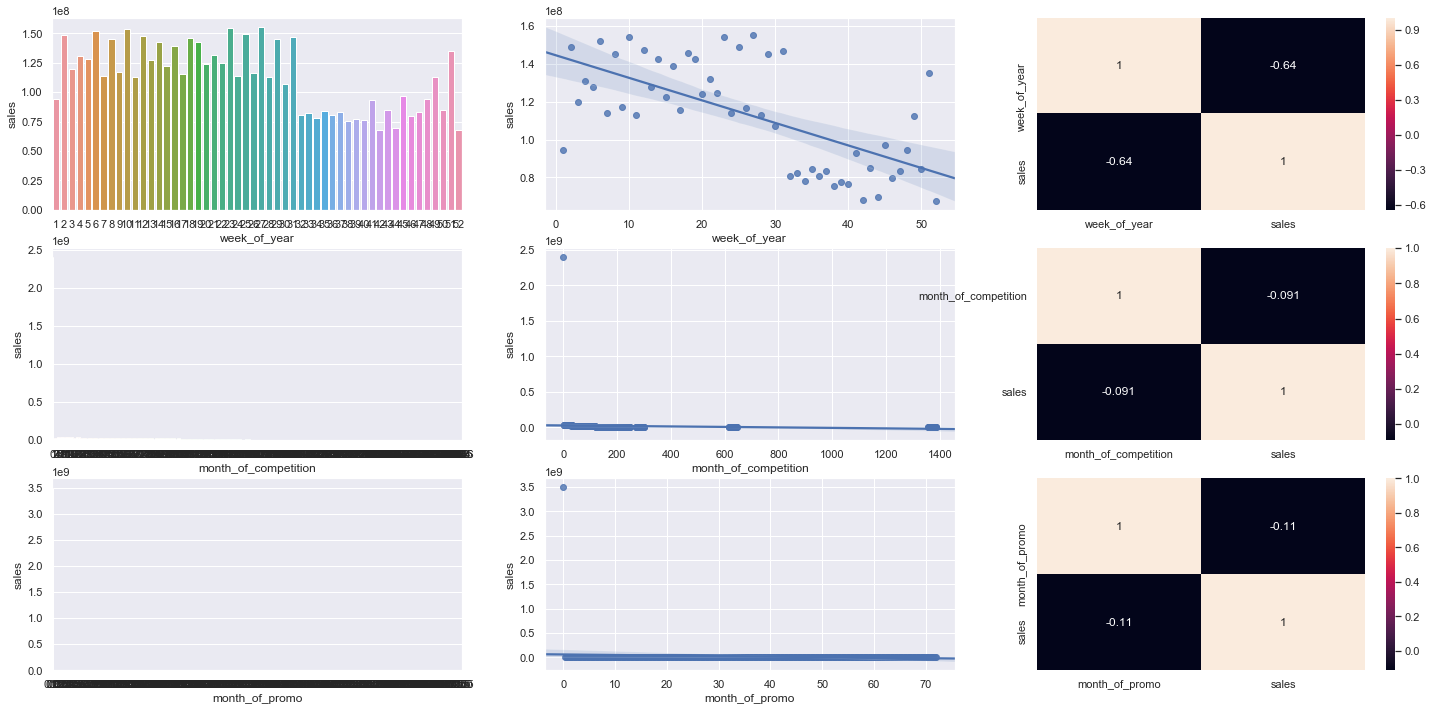

In [44]:
# ----------------------------
# week_of_year
# ----------------------------
aux1 = df5[['week_of_year', 'sales']].groupby( 'week_of_year' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )

plt.subplot( 3, 3, 1 )
sns.barplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 2 )
sns.regplot( x='week_of_year', y='sales', data=aux1 )

plt.subplot( 3, 3, 3 )
sns.heatmap( cor1, annot=True )

# -------------------
# month of competition
# -------------------
aux1 = df5[['month_of_competition', 'sales']].groupby( 'month_of_competition' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 4 )
sns.barplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 5 )
sns.regplot( x='month_of_competition', y='sales', data=aux1 )

plt.subplot( 3, 3, 6 )
sns.heatmap( cor1, annot=True )

# -------------------
# month_of_promo
# -------------------
aux1 = df5[['month_of_promo', 'sales']].groupby( 'month_of_promo' ).sum().reset_index()
cor1 = aux1.corr( method='pearson' )
plt.subplot( 3, 3, 7 )
sns.barplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 8 )
sns.regplot( x='month_of_promo', y='sales', data=aux1 )

plt.subplot( 3, 3, 9 )
sns.heatmap( cor1, annot=True )


### 5.2.2. Categorical Predictors

In [45]:
cat_attributes.head()

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,regular_day,a,basic
2,regular_day,a,basic
3,regular_day,c,extended
4,regular_day,a,basic


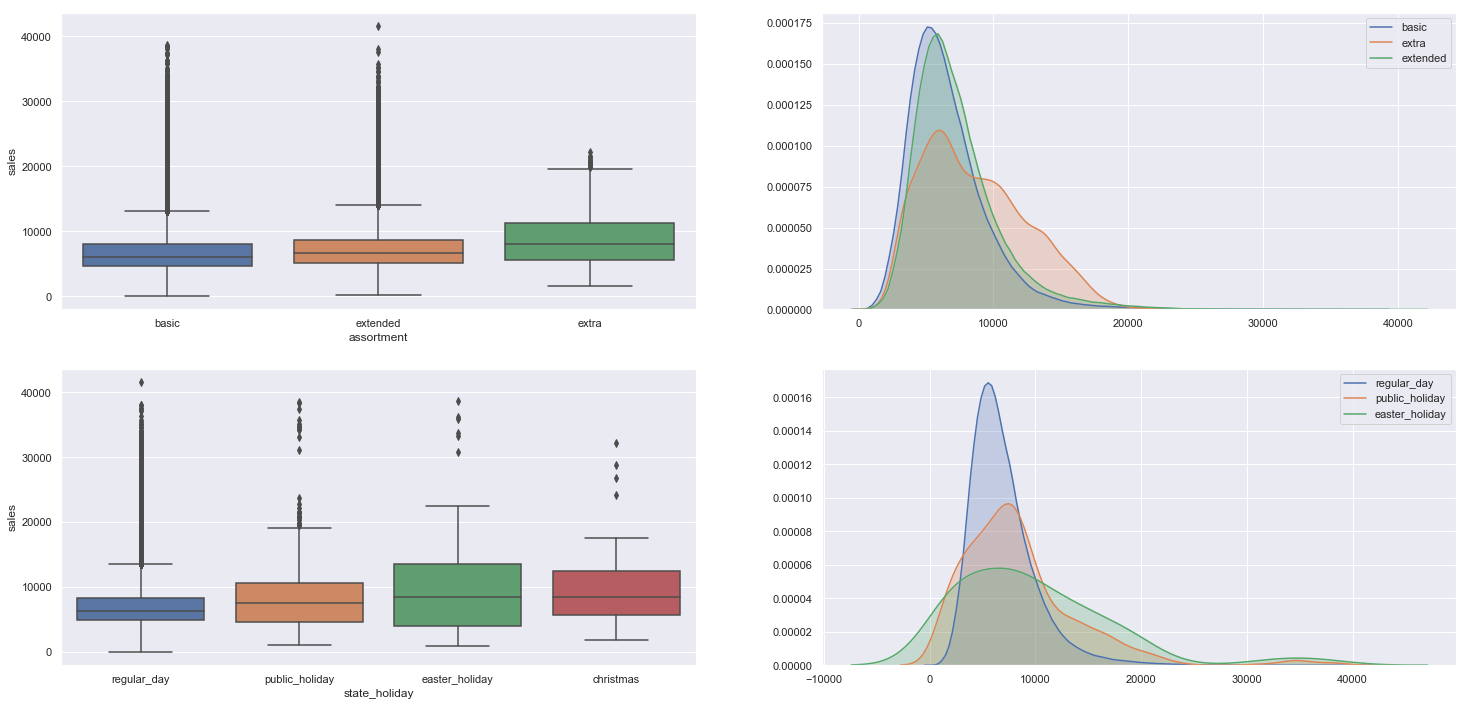

In [46]:
# Assortment X Sales
plt.subplot( 2, 2, 1 )
sns.boxplot( x='assortment', y='sales', data=df5 )

plt.subplot( 2, 2, 2 )
sns.kdeplot( df5[df5['assortment'] == 'basic']['sales'], label='basic', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extra']['sales'], label='extra', shade=True );
sns.kdeplot( df5[df5['assortment'] == 'extended']['sales'], label='extended', shade=True );

# State Holiday X Sales
plt.subplot( 2, 2, 3 )
sns.boxplot( x='state_holiday', y='sales', data=df5 )

plt.subplot( 2, 2, 4 )
sns.kdeplot( df5[df5['state_holiday'] == 'regular_day']['sales'], label='regular_day', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True );
sns.kdeplot( df5[df5['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True );

## 5.3. Multivariate Analysis

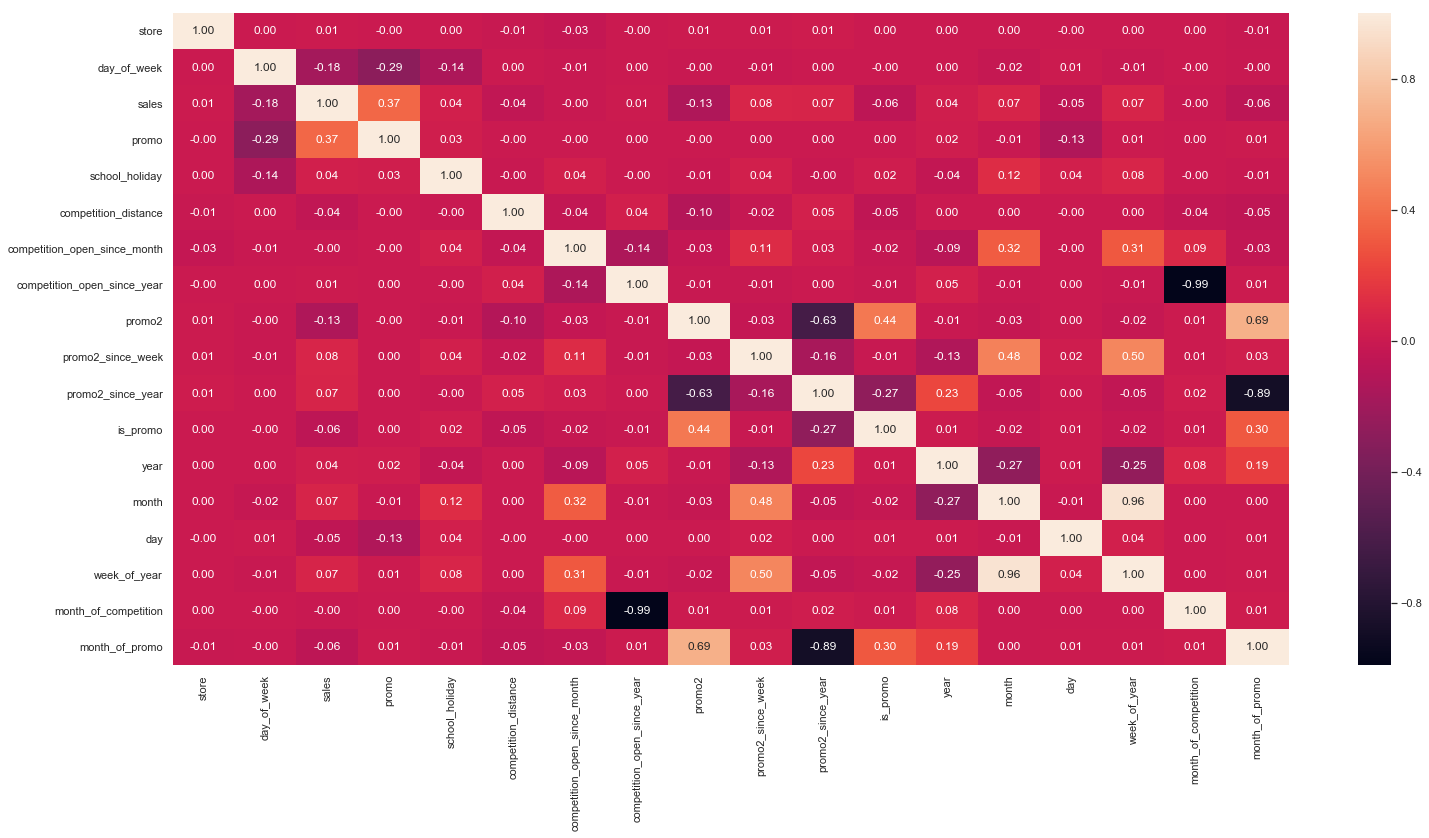

In [47]:
correlation = num_attributes.corr()
sns.heatmap( correlation, annot=True, fmt='.2f' )

plt.show()

# 6.0. DATA PREPARATION
---

In [48]:
df6 = df5.copy()

## 6.1. Numerical Predictors

### 6.1.1. Normalization ( Rescaling )

In [49]:
mms = MinMaxScaler()

In [50]:
# competition distance
df6['competition_distance'] = mms.fit_transform( df6[['competition_distance']].values )

# month of promotion
df6['month_of_promo'] = mms.fit_transform( df6[['month_of_promo']].values )

# competition open since year
df6['competition_open_since_year'] = mms.fit_transform( df6[['competition_open_since_year']].values ) 

# year
df6['year'] = mms.fit_transform( df6[['year']].values ) 

# promo2 since year
df6['promo2_since_year'] = mms.fit_transform( df6[['promo2_since_year']].values )

# month_of_competiton
df6['month_of_competition'] = mms.fit_transform( df6[['month_of_competition']].values )

### 6.1.2. Transformations

In [51]:
# day of year
df6['day_of_week_sin'] = df6['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df6['day_of_week_cos'] = df6['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# competition open since month
df6['competition_open_since_month_sin'] = df6['competition_open_since_month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['competition_open_since_month_cos'] = df6['competition_open_since_month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# promo 2 since week
df6['promo2_since_week_sin'] = df6['promo2_since_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['promo2_since_week_cos'] = df6['promo2_since_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# month
df6['month_sin'] = df6['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df6['month_cos'] = df6['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df6['day_sin'] = df6['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
df6['day_cos'] = df6['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )

# week_of_year
df6['week_of_year_sin'] = df6['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df6['week_of_year_cos'] = df6['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

df6 = df6.drop( ['day_of_week', 'competition_open_since_month', 'promo2_since_week', 'month', 'day', 'week_of_year'], axis=1 )

## 6.2. Categorical Predictors

### 6.2.1. Label Encoding

In [52]:
# Label Encoder
le = LabelEncoder()

# state holiday
df6['state_holiday'] = df6['state_holiday'].apply( lambda x: 1 if x == 'regular_day' else 0 )
df6 = df6.rename( columns={'state_holiday':'regular_day'})

# store_type
le.fit( df6['store_type'].drop_duplicates() )
df6['store_type'] = le.transform( df6['store_type'] )

# assortment
le.fit( df6['assortment'].drop_duplicates() )
df6['assortment'] = le.transform( df6['assortment'] )

## 6.3. Response Variable

### 6.3.1. Transformations

In [53]:
# Log transformation
df6['sales'] =  np.log1p( df6['sales'] )

In [54]:
df6.sample( 3 )

,store,date,sales,promo,regular_day,school_holiday,store_type,assortment,competition_distance,competition_open_since_year,promo2,promo2_since_year,is_promo,year,month_of_competition,month_of_promo,day_of_week_sin,day_of_week_cos,competition_open_since_month_sin,competition_open_since_month_cos,promo2_since_week_sin,promo2_since_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
18655,816,2015-07-15,8.563122,1,1,1,2,1,0.002200,1.000000,0,1.000000,0,1.0,0.000000,0.0,0.433884,-0.900969,-0.500000,-8.660254e-01,-0.354605,-0.935016,-0.5,-8.660254e-01,0.101168,-0.994869,-0.354605,-0.935016
214434,355,2015-01-20,8.938663,0,1,0,0,1,0.048505,0.982609,0,1.000000,0,1.0,0.012266,0.0,0.974928,-0.222521,-0.866025,-5.000000e-01,0.464723,0.885456,0.5,8.660254e-01,-0.790776,-0.612106,0.464723,0.885456
537070,426,2014-03-07,8.729882,1,1,0,0,0,0.001150,0.991304,0,0.833333,0,0.5,0.000000,0.0,-0.974928,-0.222521,1.000000,6.123234e-17,0.935016,0.354605,1.0,6.123234e-17,0.988468,0.151428,0.935016,0.354605


# 7.0. FEATURE SELECTION
---

In [55]:
df7 = df6.copy()

## 7.1. Split training and test dataset

In [56]:
# split the last 6 weeks data as hold-out set
df7 = df7.sort_values( 'date', ascending=False )

## split training and test dataset
# training
X_train = df7[6*7*1115:]
y_train = X_train['sales']

# test
X_test = df7[:6*7*1115]
y_test = X_test['sales']

In [57]:
# Drop attributes
X_train = X_train.drop( ['sales', 'date'], axis=1 )
X_test = X_test.drop( ['sales', 'date'], axis=1 )

## 7.2. RFECV Selection ( Recursive Feature Elimination Cross Validation )

In [ ]:
# define the estimator
estimator = RandomForestRegressor( n_jobs=-1 )

# fit the RFE
rfecv = RFECV( estimator=estimator, cv=10, scoring='r2', n_jobs=-1, verbose=1 ).fit( X_train, y_train )

# select variables and calculate test accuracy
cols_selected = X_train.columns[ rfecv.support_ ]

# select the best features
X_train_rfecv = X_train[ cols_selected ]
X_train_rfecv['sales'] = y_train

# features selected and not selected
cols_selected_rfecv = X_train_rfecv.columns.to_list()
cols_not_selected_rfecv = list( np.setdiff1d( X_train.columns, X_train_rfecv.columns ) )

# 20 min
# features: store, promo, competition_distance, sales

In [78]:
X_train.columns.to_list()

['store',
 'promo',
 'regular_day',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_year',
 'promo2',
 'promo2_since_year',
 'is_promo',
 'year',
 'month_of_competition',
 'month_of_promo',
 'day_of_week_sin',
 'day_of_week_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'promo2_since_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [71]:
data.columns.to_list()

['store',
 'promo',
 'school_holiday',
 'assortment',
 'promo2',
 'year',
 'day_of_week_sin',
 'day_of_week_cos',
 'competition_open_since_month_sin',
 'competition_open_since_month_cos',
 'promo2_since_week_sin',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'sales']

In [77]:
list( np.setdiff1d( X_train.columns, data.columns ) )

['competition_distance',
 'competition_open_since_year',
 'is_promo',
 'month_cos',
 'month_of_competition',
 'month_of_promo',
 'promo2_since_week_cos',
 'promo2_since_year',
 'regular_day',
 'store_type',
 'week_of_year_sin']

## 7.3. Embedded Method

In [ ]:
# Linear Regression - Lasso CV Regularization
reg = LassoCV( 0.01 )

reg.fit( X_train, y_train )
print( 'Best alpha using built-in LassoCV: {}'.format( reg.alpha_ ) )
print( 'Best score using built-in LassoCV: {}'.format( reg.score( X_train, y_train ) ) )

coef = pd.Series( reg.coef_, index=X_train.columns )

cols_selected = list( coef[coef != 0].index )
print( 'Lasso picked ' + str( sum( coef != 0 ) ) + ' variables and eliminated the other ' + str( sum( coef == 0 ) ) + ' variables' )

# plot importances
imp_coef = coef.sort_values()
imp_coef.plot( kind='barh' )
plt.title( 'Feature importance using Lasso Model' );

# select the best features
data = X_train[ cols_selected ]
data['sales'] = y_train

# cols
## cols_selected = 'month_of_promo', 'promo2_since_year', 'promo', 'assortment', 'day_of_week_cos', 'school_holiday', 'day_cos', 'month_sin', 'day_of_week_sin', 'month_cos', 'day_sin', ''

## 7.4. Boruta Feature Selection

In [ ]:
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

# define random forest regressor
rf = RandomForestRegressor( n_jobs=-1 )

# define Boruta features selection method
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=1 ).fit( X_train_n, y_train_n )

# selecting features based on the chosen ranking
rank_list = [1]
cols_selected = [ True if x in rank_list else False for x in boruta.ranking_ ]

# select the best features
X_train_boruta = X_train.iloc[:, cols_selected]
X_train_boruta['sales'] = y_train

# features selected and not selected
cols_selected_boruta = X_train_boruta.columns.to_list()
cols_not_selected_boruta = list( np.setdiff1d( X_train.columns, X_train_boruta.columns ) )

## 7.5. Manual Feature Selection

In [63]:
col_selected =  ['store', 'store_type', 'assortment', 'promo', 'month_of_promo', 'promo2', 'promo2_since_year', 'promo2_since_week_sin', 'promo2_since_week_cos', 'competition_distance', 
    'competition_open_since_month_sin', 'competition_open_since_month_cos', 'competition_open_since_year', 'month_of_competition', 'day_of_week_sin', 'day_of_week_cos', 'day_sin', 'day_cos', 
    'month_cos', 'week_of_year_cos']

col_deleted = ['regular_day', 'school_holiday', 'is_promo', 'year', 'month_sin', 'week_of_year_sin']

# 8.0. MACHINE LEARNING MODELLING
---

In [64]:
X_train = X_train[ col_selected ]
X_test = X_test[ col_selec]

## 8.1. Average Model ( Baseline Model )

In [230]:
# dataset
aux = X_test.copy()
aux['sales'] = y_test.copy()

# predictions
yhat_store = aux[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux, yhat_store, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance 
baseline_results = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
print( baseline_results )

           Model     RMSPE         RMSE          MAE
0  Average Model  0.726751  1878.694596  1400.295276


## 8.2. Linear Regression

In [231]:
# model
lr = LinearRegression().fit( X_train, y_train )

# predictions
yhat_lr = lr.predict( X_test )

# performance 
lr_results = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
print( lr_results )

# RMSPE 0.439315  RMSE 2719.583353  MAE 1928.658545

               Model    RMSPE         RMSE          MAE
0  Linear Regression  0.42273  2735.070038  1904.412007


### 8.2.1. Cross Validation

In [ ]:
# K-Fold Cross Validation
lr_rmspe_score = [] 
lr_rmse_score = []
lr_mae_score = []

k = 10
cv = KFold( n_splits=k, random_state=42, shuffle=False )

# iterate over folds
for train_index, test_index in cv.split( X_train ):
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = X_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[train_index], y_test.iloc[test_index]
    
    # model fit
    lr_cv = LinearRegression().fit( X_train_cv, y_train_cv )
    
    # predictions
    yhat_lr_cv = lr_cv.predict( X_test_cv )
    
    # performance
    ## rmspe
    lr_rmspe_score.append( rmspe( np.expm1( y_test_cv ), np.expm1( yhat_lr_cv ) ) )
    ## mae
    lr_mae_score.append( mae( np.expm1( y_test_cv ), np.expm1( yhat_lr_cv ) ) )
    ## rmse
    lr_rmse_score.append( np.sqrt( mean_squared_error( np.expm1( y_test_cv ), np.expm1( yhat_lr_cv ) ) ) )
    
print( 'LR RMSE CV: {} +/- {}'.format( np.round( np.mean( lm_rmse_score ), 0 ), np.round( np.std( lm_rmse_score ), 0 ) ) )
print( 'LR RMSPE CV: {} +/- {}'.format( np.round( np.mean( lm_rmspe_score ), 0 ), np.round( np.std( lm_rmspe_score ), 0 ) ) )
print( 'LR MAE CV: {} +/- {}'.format( np.round( np.mean( lm_mae_score ), 0 ), np.round( np.std( lm_mae_score ), 0 ) ) )

## 8.3. Linear Regression Regularized

In [232]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# predictions
yhat_lrr = lrr.predict( X_test )

# performance 
lrr_results = ml_error( 'Linear Regression Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
print( lrr_results )

# RMSPE 0.426222  RMSE 2771.655845  MAE 1931.954218

                     Model     RMSPE         RMSE          MAE
0  Linear Regression Lasso  0.421829  2821.559413  1940.105968


## 8.4. Random Forest Regressor

In [233]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=0 ).fit( X_train, y_train )

# predictions
yhat_rf = rf.predict( X_test )

# performance
rf_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
print( rf_results )

# 5 min, RMSPE 0.147634, RMSE 1060.412205, MAE 715.623667
# 7 min, RMSPE 0.137651, RMSE 0.137651, MAE 682.335742

                     Model     RMSPE         RMSE         MAE
0  Random Forest Regressor  0.137651  1014.232429  682.335742


## 8.5. SVR ( Support Vector Regressor )

In [ ]:
# model
svr = SVR( kernel='rbf', C=0.1, verbose=2 ).fit( X_train, y_train )

# predictions
yhat_svr = svr.predict( X_test )

# performance
svr_results = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_svr ) )
print( svr_results )

## 8.5. XGBoost Regressor

### 8.5.1. Training

In [234]:
# parameters
params = { 
    'objective': 'reg:linear', 
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10 
         }
num_boost_round = 6000

# training
dtrain = xgb.DMatrix( X_train, y_train )
dvalid = xgb.DMatrix( X_test, y_test )
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

print( '===> start: XGBoost training')
start = time()
gbm = xgb.train( params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True )
end = time()
print( '===> end: XGBoost training')

===> start: XGBoost training
[0]	train-rmse:8.01958	eval-rmse:8.04698	train-rmspe:0.999808	eval-rmspe:0.999814
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.77948	eval-rmse:7.80672	train-rmspe:0.99971	eval-rmspe:0.999719
[2]	train-rmse:7.54657	eval-rmse:7.5735	train-rmspe:0.99959	eval-rmspe:0.999603
[3]	train-rmse:7.32066	eval-rmse:7.34725	train-rmspe:0.999444	eval-rmspe:0.999461
[4]	train-rmse:7.10152	eval-rmse:7.1281	train-rmspe:0.999267	eval-rmspe:0.999289
[5]	train-rmse:6.88898	eval-rmse:6.91551	train-rmspe:0.999054	eval-rmspe:0.999083
[6]	train-rmse:6.68289	eval-rmse:6.70926	train-rmspe:0.998799	eval-rmspe:0.998835
[7]	train-rmse:6.48296	eval-rmse:6.5084	train-rmspe:0.998497	eval-rmspe:0.998541
[8]	train-rmse:6.28908	eval-rmse:6.31418	train-rmspe:0.998141	eval-rmspe:0.998194
[9]	train-rmse:6.10093	eval-rmse:6.12531	train-rmspe:0.997723	eval-rmspe:0.997787
[10]	train

[97]	train-rmse:0.490817	eval-rmse:0.492937	train-rmspe:0.37964	eval-rmspe:0.369736
[98]	train-rmse:0.480051	eval-rmse:0.482274	train-rmspe:0.373823	eval-rmspe:0.363513
[99]	train-rmse:0.469554	eval-rmse:0.471597	train-rmspe:0.368183	eval-rmspe:0.357288
[100]	train-rmse:0.459004	eval-rmse:0.461095	train-rmspe:0.362554	eval-rmspe:0.351183
[101]	train-rmse:0.449104	eval-rmse:0.451215	train-rmspe:0.357173	eval-rmspe:0.345378
[102]	train-rmse:0.439447	eval-rmse:0.441236	train-rmspe:0.352018	eval-rmspe:0.339557
[103]	train-rmse:0.430517	eval-rmse:0.431986	train-rmspe:0.347256	eval-rmspe:0.334085
[104]	train-rmse:0.421595	eval-rmse:0.422998	train-rmspe:0.342515	eval-rmspe:0.328802
[105]	train-rmse:0.413263	eval-rmse:0.414111	train-rmspe:0.338082	eval-rmspe:0.323531
[106]	train-rmse:0.405327	eval-rmse:0.405812	train-rmspe:0.333905	eval-rmspe:0.318661
[107]	train-rmse:0.397228	eval-rmse:0.39754	train-rmspe:0.329709	eval-rmspe:0.313836
[108]	train-rmse:0.389258	eval-rmse:0.38953	train-rmspe:0.3

[193]	train-rmse:0.204143	eval-rmse:0.211128	train-rmspe:0.248417	eval-rmspe:0.223321
[194]	train-rmse:0.203905	eval-rmse:0.210945	train-rmspe:0.24844	eval-rmspe:0.223372
[195]	train-rmse:0.20255	eval-rmse:0.209687	train-rmspe:0.247402	eval-rmspe:0.222205
[196]	train-rmse:0.202275	eval-rmse:0.209467	train-rmspe:0.24735	eval-rmspe:0.222118
[197]	train-rmse:0.201191	eval-rmse:0.208452	train-rmspe:0.246528	eval-rmspe:0.22126
[198]	train-rmse:0.200561	eval-rmse:0.208021	train-rmspe:0.246022	eval-rmspe:0.22108
[199]	train-rmse:0.200192	eval-rmse:0.207774	train-rmspe:0.245848	eval-rmspe:0.22097
[200]	train-rmse:0.199978	eval-rmse:0.207631	train-rmspe:0.245867	eval-rmspe:0.221129
[201]	train-rmse:0.198987	eval-rmse:0.206609	train-rmspe:0.245124	eval-rmspe:0.220176
[202]	train-rmse:0.198659	eval-rmse:0.206375	train-rmspe:0.245074	eval-rmspe:0.220127
[203]	train-rmse:0.197316	eval-rmse:0.205153	train-rmspe:0.243939	eval-rmspe:0.218787
[204]	train-rmse:0.196606	eval-rmse:0.20453	train-rmspe:0.24

[289]	train-rmse:0.163991	eval-rmse:0.176447	train-rmspe:0.217394	eval-rmspe:0.191576
[290]	train-rmse:0.163787	eval-rmse:0.176257	train-rmspe:0.217225	eval-rmspe:0.191363
[291]	train-rmse:0.163006	eval-rmse:0.175559	train-rmspe:0.216464	eval-rmspe:0.190627
[292]	train-rmse:0.162293	eval-rmse:0.174948	train-rmspe:0.215784	eval-rmspe:0.189964
[293]	train-rmse:0.162006	eval-rmse:0.174678	train-rmspe:0.215548	eval-rmspe:0.189688
[294]	train-rmse:0.161957	eval-rmse:0.174638	train-rmspe:0.214872	eval-rmspe:0.189653
[295]	train-rmse:0.161709	eval-rmse:0.174442	train-rmspe:0.214673	eval-rmspe:0.189378
[296]	train-rmse:0.161069	eval-rmse:0.17388	train-rmspe:0.214096	eval-rmspe:0.188782
[297]	train-rmse:0.160835	eval-rmse:0.173658	train-rmspe:0.213907	eval-rmspe:0.18854
[298]	train-rmse:0.160679	eval-rmse:0.173566	train-rmspe:0.213811	eval-rmspe:0.188482
[299]	train-rmse:0.160632	eval-rmse:0.173529	train-rmspe:0.213529	eval-rmspe:0.188447
[300]	train-rmse:0.160412	eval-rmse:0.173327	train-rmspe

[385]	train-rmse:0.141327	eval-rmse:0.156933	train-rmspe:0.191927	eval-rmspe:0.170006
[386]	train-rmse:0.141036	eval-rmse:0.156687	train-rmspe:0.191682	eval-rmspe:0.16973
[387]	train-rmse:0.140975	eval-rmse:0.156639	train-rmspe:0.191633	eval-rmspe:0.169681
[388]	train-rmse:0.140813	eval-rmse:0.156476	train-rmspe:0.191498	eval-rmspe:0.169507
[389]	train-rmse:0.140557	eval-rmse:0.156255	train-rmspe:0.191118	eval-rmspe:0.169268
[390]	train-rmse:0.140302	eval-rmse:0.156058	train-rmspe:0.190867	eval-rmspe:0.169046
[391]	train-rmse:0.140204	eval-rmse:0.155971	train-rmspe:0.190782	eval-rmspe:0.168941
[392]	train-rmse:0.139996	eval-rmse:0.155766	train-rmspe:0.190457	eval-rmspe:0.168712
[393]	train-rmse:0.139845	eval-rmse:0.155616	train-rmspe:0.190318	eval-rmspe:0.168544
[394]	train-rmse:0.139654	eval-rmse:0.155475	train-rmspe:0.190027	eval-rmspe:0.1684
[395]	train-rmse:0.139604	eval-rmse:0.155422	train-rmspe:0.189981	eval-rmspe:0.168347
[396]	train-rmse:0.139348	eval-rmse:0.155198	train-rmspe:

[481]	train-rmse:0.125518	eval-rmse:0.143728	train-rmspe:0.17474	eval-rmspe:0.155151
[482]	train-rmse:0.12522	eval-rmse:0.143486	train-rmspe:0.174437	eval-rmspe:0.154864
[483]	train-rmse:0.124949	eval-rmse:0.143255	train-rmspe:0.174222	eval-rmspe:0.15459
[484]	train-rmse:0.124922	eval-rmse:0.143232	train-rmspe:0.174204	eval-rmspe:0.154567
[485]	train-rmse:0.124832	eval-rmse:0.143161	train-rmspe:0.174075	eval-rmspe:0.154477
[486]	train-rmse:0.124599	eval-rmse:0.142953	train-rmspe:0.173874	eval-rmspe:0.154234
[487]	train-rmse:0.124542	eval-rmse:0.142904	train-rmspe:0.173826	eval-rmspe:0.15418
[488]	train-rmse:0.124395	eval-rmse:0.142833	train-rmspe:0.173699	eval-rmspe:0.154112
[489]	train-rmse:0.124207	eval-rmse:0.142671	train-rmspe:0.17353	eval-rmspe:0.153945
[490]	train-rmse:0.123943	eval-rmse:0.142345	train-rmspe:0.173316	eval-rmspe:0.153566
[491]	train-rmse:0.123797	eval-rmse:0.142231	train-rmspe:0.173108	eval-rmspe:0.153435
[492]	train-rmse:0.123675	eval-rmse:0.142145	train-rmspe:0.

[577]	train-rmse:0.114905	eval-rmse:0.134801	train-rmspe:0.164621	eval-rmspe:0.144955
[578]	train-rmse:0.114811	eval-rmse:0.134736	train-rmspe:0.164534	eval-rmspe:0.144871
[579]	train-rmse:0.114735	eval-rmse:0.134684	train-rmspe:0.16446	eval-rmspe:0.144812
[580]	train-rmse:0.114676	eval-rmse:0.134632	train-rmspe:0.164407	eval-rmspe:0.144757
[581]	train-rmse:0.114515	eval-rmse:0.134516	train-rmspe:0.164186	eval-rmspe:0.144638
[582]	train-rmse:0.114481	eval-rmse:0.134489	train-rmspe:0.164159	eval-rmspe:0.144609
[583]	train-rmse:0.11439	eval-rmse:0.134408	train-rmspe:0.164002	eval-rmspe:0.144514
[584]	train-rmse:0.114284	eval-rmse:0.13434	train-rmspe:0.16384	eval-rmspe:0.144414
[585]	train-rmse:0.114149	eval-rmse:0.134238	train-rmspe:0.163712	eval-rmspe:0.14429
[586]	train-rmse:0.114058	eval-rmse:0.13411	train-rmspe:0.163607	eval-rmspe:0.144141
[587]	train-rmse:0.114039	eval-rmse:0.134118	train-rmspe:0.163581	eval-rmspe:0.144137
[588]	train-rmse:0.113969	eval-rmse:0.134061	train-rmspe:0.1

[673]	train-rmse:0.107762	eval-rmse:0.129048	train-rmspe:0.158	eval-rmspe:0.138176
[674]	train-rmse:0.107666	eval-rmse:0.129025	train-rmspe:0.157927	eval-rmspe:0.138135
[675]	train-rmse:0.107603	eval-rmse:0.128982	train-rmspe:0.157816	eval-rmspe:0.138088
[676]	train-rmse:0.107536	eval-rmse:0.128923	train-rmspe:0.157757	eval-rmspe:0.138018
[677]	train-rmse:0.107428	eval-rmse:0.128833	train-rmspe:0.157679	eval-rmspe:0.137921
[678]	train-rmse:0.107273	eval-rmse:0.128709	train-rmspe:0.157544	eval-rmspe:0.137783
[679]	train-rmse:0.107248	eval-rmse:0.128693	train-rmspe:0.157526	eval-rmspe:0.137768
[680]	train-rmse:0.107239	eval-rmse:0.128688	train-rmspe:0.157523	eval-rmspe:0.137764
[681]	train-rmse:0.107184	eval-rmse:0.128661	train-rmspe:0.15748	eval-rmspe:0.137742
[682]	train-rmse:0.107161	eval-rmse:0.128641	train-rmspe:0.157461	eval-rmspe:0.137715
[683]	train-rmse:0.107054	eval-rmse:0.128524	train-rmspe:0.157358	eval-rmspe:0.137581
[684]	train-rmse:0.106994	eval-rmse:0.128489	train-rmspe:0

[769]	train-rmse:0.102028	eval-rmse:0.124934	train-rmspe:0.152319	eval-rmspe:0.133224
[770]	train-rmse:0.101969	eval-rmse:0.124896	train-rmspe:0.152171	eval-rmspe:0.133189
[771]	train-rmse:0.101939	eval-rmse:0.124879	train-rmspe:0.152136	eval-rmspe:0.133171
[772]	train-rmse:0.101903	eval-rmse:0.12484	train-rmspe:0.152107	eval-rmspe:0.133098
[773]	train-rmse:0.101861	eval-rmse:0.124815	train-rmspe:0.152076	eval-rmspe:0.133072
[774]	train-rmse:0.101809	eval-rmse:0.12478	train-rmspe:0.152028	eval-rmspe:0.133037
[775]	train-rmse:0.101745	eval-rmse:0.124736	train-rmspe:0.151966	eval-rmspe:0.132992
[776]	train-rmse:0.101717	eval-rmse:0.124719	train-rmspe:0.151907	eval-rmspe:0.132974
[777]	train-rmse:0.10165	eval-rmse:0.124682	train-rmspe:0.151855	eval-rmspe:0.132933
[778]	train-rmse:0.101592	eval-rmse:0.124641	train-rmspe:0.151795	eval-rmspe:0.13289
[779]	train-rmse:0.101551	eval-rmse:0.1246	train-rmspe:0.151756	eval-rmspe:0.132836
[780]	train-rmse:0.101513	eval-rmse:0.124548	train-rmspe:0.1

[865]	train-rmse:0.098094	eval-rmse:0.122118	train-rmspe:0.142473	eval-rmspe:0.130061
[866]	train-rmse:0.098065	eval-rmse:0.122102	train-rmspe:0.142447	eval-rmspe:0.130052
[867]	train-rmse:0.097983	eval-rmse:0.122053	train-rmspe:0.142274	eval-rmspe:0.129996
[868]	train-rmse:0.09792	eval-rmse:0.122015	train-rmspe:0.142201	eval-rmspe:0.129953
[869]	train-rmse:0.097911	eval-rmse:0.122012	train-rmspe:0.142188	eval-rmspe:0.129952
[870]	train-rmse:0.097895	eval-rmse:0.121999	train-rmspe:0.142176	eval-rmspe:0.129938
[871]	train-rmse:0.097835	eval-rmse:0.121956	train-rmspe:0.142125	eval-rmspe:0.129893
[872]	train-rmse:0.097789	eval-rmse:0.121892	train-rmspe:0.142088	eval-rmspe:0.129824
[873]	train-rmse:0.097759	eval-rmse:0.121872	train-rmspe:0.142065	eval-rmspe:0.129804
[874]	train-rmse:0.097717	eval-rmse:0.121828	train-rmspe:0.142032	eval-rmspe:0.129756
[875]	train-rmse:0.097698	eval-rmse:0.121804	train-rmspe:0.142017	eval-rmspe:0.129724
[876]	train-rmse:0.097618	eval-rmse:0.121747	train-rmsp

[961]	train-rmse:0.094703	eval-rmse:0.119994	train-rmspe:0.138167	eval-rmspe:0.127728
[962]	train-rmse:0.094666	eval-rmse:0.119974	train-rmspe:0.13812	eval-rmspe:0.127707
[963]	train-rmse:0.09462	eval-rmse:0.119937	train-rmspe:0.138083	eval-rmspe:0.127669
[964]	train-rmse:0.094612	eval-rmse:0.119934	train-rmspe:0.138077	eval-rmspe:0.127666
[965]	train-rmse:0.094572	eval-rmse:0.119911	train-rmspe:0.138038	eval-rmspe:0.127643
[966]	train-rmse:0.094533	eval-rmse:0.119888	train-rmspe:0.137994	eval-rmspe:0.127618
[967]	train-rmse:0.094502	eval-rmse:0.119864	train-rmspe:0.137963	eval-rmspe:0.127588
[968]	train-rmse:0.094477	eval-rmse:0.11986	train-rmspe:0.137942	eval-rmspe:0.12758
[969]	train-rmse:0.09444	eval-rmse:0.11985	train-rmspe:0.137895	eval-rmspe:0.127565
[970]	train-rmse:0.09441	eval-rmse:0.119838	train-rmspe:0.137869	eval-rmspe:0.127552
[971]	train-rmse:0.094396	eval-rmse:0.11983	train-rmspe:0.137857	eval-rmspe:0.127544
[972]	train-rmse:0.094373	eval-rmse:0.119819	train-rmspe:0.137

[1057]	train-rmse:0.091856	eval-rmse:0.118559	train-rmspe:0.134748	eval-rmspe:0.126087
[1058]	train-rmse:0.091827	eval-rmse:0.118543	train-rmspe:0.134714	eval-rmspe:0.126069
[1059]	train-rmse:0.091783	eval-rmse:0.11852	train-rmspe:0.134675	eval-rmspe:0.126043
[1060]	train-rmse:0.091742	eval-rmse:0.118504	train-rmspe:0.13464	eval-rmspe:0.126029
[1061]	train-rmse:0.091736	eval-rmse:0.118507	train-rmspe:0.134637	eval-rmspe:0.126035
[1062]	train-rmse:0.091722	eval-rmse:0.118504	train-rmspe:0.134619	eval-rmspe:0.126036
[1063]	train-rmse:0.09171	eval-rmse:0.118492	train-rmspe:0.134605	eval-rmspe:0.126024
[1064]	train-rmse:0.09169	eval-rmse:0.118472	train-rmspe:0.134586	eval-rmspe:0.125997
[1065]	train-rmse:0.091649	eval-rmse:0.11845	train-rmspe:0.134557	eval-rmspe:0.125973
[1066]	train-rmse:0.091614	eval-rmse:0.118433	train-rmspe:0.134533	eval-rmspe:0.125956
[1067]	train-rmse:0.091588	eval-rmse:0.118405	train-rmspe:0.134494	eval-rmspe:0.125926
[1068]	train-rmse:0.091579	eval-rmse:0.118401	tr

[1152]	train-rmse:0.089594	eval-rmse:0.117496	train-rmspe:0.129971	eval-rmspe:0.124931
[1153]	train-rmse:0.089567	eval-rmse:0.11749	train-rmspe:0.129947	eval-rmspe:0.124924
[1154]	train-rmse:0.089542	eval-rmse:0.117478	train-rmspe:0.129927	eval-rmspe:0.124911
[1155]	train-rmse:0.089531	eval-rmse:0.117465	train-rmspe:0.129919	eval-rmspe:0.124896
[1156]	train-rmse:0.089503	eval-rmse:0.117447	train-rmspe:0.129893	eval-rmspe:0.124874
[1157]	train-rmse:0.089482	eval-rmse:0.117447	train-rmspe:0.129584	eval-rmspe:0.124873
[1158]	train-rmse:0.089455	eval-rmse:0.117435	train-rmspe:0.129558	eval-rmspe:0.124867
[1159]	train-rmse:0.089435	eval-rmse:0.117427	train-rmspe:0.129548	eval-rmspe:0.124855
[1160]	train-rmse:0.089424	eval-rmse:0.117423	train-rmspe:0.12954	eval-rmspe:0.124851
[1161]	train-rmse:0.089413	eval-rmse:0.117414	train-rmspe:0.129524	eval-rmspe:0.124844
[1162]	train-rmse:0.089396	eval-rmse:0.117403	train-rmspe:0.129504	eval-rmspe:0.124838
[1163]	train-rmse:0.089365	eval-rmse:0.117385

[1247]	train-rmse:0.087415	eval-rmse:0.116694	train-rmspe:0.122148	eval-rmspe:0.123967
[1248]	train-rmse:0.087397	eval-rmse:0.1167	train-rmspe:0.122133	eval-rmspe:0.123975
[1249]	train-rmse:0.087393	eval-rmse:0.116709	train-rmspe:0.122129	eval-rmspe:0.12399
[1250]	train-rmse:0.087373	eval-rmse:0.116695	train-rmspe:0.122101	eval-rmspe:0.123975
[1251]	train-rmse:0.087353	eval-rmse:0.116689	train-rmspe:0.122083	eval-rmspe:0.123967
[1252]	train-rmse:0.087324	eval-rmse:0.116683	train-rmspe:0.122056	eval-rmspe:0.123957
[1253]	train-rmse:0.087299	eval-rmse:0.11667	train-rmspe:0.122037	eval-rmspe:0.123942
[1254]	train-rmse:0.087275	eval-rmse:0.116659	train-rmspe:0.122015	eval-rmspe:0.123929
[1255]	train-rmse:0.087248	eval-rmse:0.116647	train-rmspe:0.121984	eval-rmspe:0.123916
[1256]	train-rmse:0.087239	eval-rmse:0.116643	train-rmspe:0.121975	eval-rmspe:0.123911
[1257]	train-rmse:0.08722	eval-rmse:0.116637	train-rmspe:0.121961	eval-rmspe:0.123903
[1258]	train-rmse:0.087205	eval-rmse:0.116645	tr

[1342]	train-rmse:0.085648	eval-rmse:0.115977	train-rmspe:0.120168	eval-rmspe:0.123208
[1343]	train-rmse:0.085633	eval-rmse:0.115972	train-rmspe:0.120155	eval-rmspe:0.123202
[1344]	train-rmse:0.085621	eval-rmse:0.115974	train-rmspe:0.120143	eval-rmspe:0.123203
[1345]	train-rmse:0.0856	eval-rmse:0.115967	train-rmspe:0.120124	eval-rmspe:0.123192
[1346]	train-rmse:0.08559	eval-rmse:0.115961	train-rmspe:0.120115	eval-rmspe:0.123185
[1347]	train-rmse:0.085583	eval-rmse:0.115963	train-rmspe:0.120109	eval-rmspe:0.123188
[1348]	train-rmse:0.085567	eval-rmse:0.115959	train-rmspe:0.120072	eval-rmspe:0.123184
[1349]	train-rmse:0.085546	eval-rmse:0.115948	train-rmspe:0.120052	eval-rmspe:0.123171
[1350]	train-rmse:0.0855	eval-rmse:0.115921	train-rmspe:0.120014	eval-rmspe:0.123141
[1351]	train-rmse:0.085458	eval-rmse:0.115898	train-rmspe:0.11998	eval-rmspe:0.123115
[1352]	train-rmse:0.085426	eval-rmse:0.115885	train-rmspe:0.119952	eval-rmspe:0.123103
[1353]	train-rmse:0.0854	eval-rmse:0.115865	train

[1437]	train-rmse:0.083796	eval-rmse:0.115377	train-rmspe:0.113738	eval-rmspe:0.122503
[1438]	train-rmse:0.083781	eval-rmse:0.115374	train-rmspe:0.113716	eval-rmspe:0.1225
[1439]	train-rmse:0.08377	eval-rmse:0.115373	train-rmspe:0.113706	eval-rmspe:0.122499
[1440]	train-rmse:0.083756	eval-rmse:0.115373	train-rmspe:0.113695	eval-rmspe:0.122498
[1441]	train-rmse:0.083733	eval-rmse:0.11536	train-rmspe:0.113674	eval-rmspe:0.122484
[1442]	train-rmse:0.083715	eval-rmse:0.115351	train-rmspe:0.113657	eval-rmspe:0.122478
[1443]	train-rmse:0.083691	eval-rmse:0.115341	train-rmspe:0.113633	eval-rmspe:0.122466
[1444]	train-rmse:0.083678	eval-rmse:0.115344	train-rmspe:0.113628	eval-rmspe:0.12247
[1445]	train-rmse:0.083667	eval-rmse:0.115338	train-rmspe:0.11362	eval-rmspe:0.122466
[1446]	train-rmse:0.083649	eval-rmse:0.115335	train-rmspe:0.113534	eval-rmspe:0.122463
[1447]	train-rmse:0.083627	eval-rmse:0.115329	train-rmspe:0.113455	eval-rmspe:0.122454
[1448]	train-rmse:0.083616	eval-rmse:0.115325	tra

[1532]	train-rmse:0.082202	eval-rmse:0.11486	train-rmspe:0.111765	eval-rmspe:0.121936
[1533]	train-rmse:0.08219	eval-rmse:0.114859	train-rmspe:0.111753	eval-rmspe:0.121935
[1534]	train-rmse:0.082172	eval-rmse:0.114855	train-rmspe:0.111739	eval-rmspe:0.121932
[1535]	train-rmse:0.082162	eval-rmse:0.11485	train-rmspe:0.111729	eval-rmspe:0.121924
[1536]	train-rmse:0.082142	eval-rmse:0.114852	train-rmspe:0.111713	eval-rmspe:0.121927
[1537]	train-rmse:0.082125	eval-rmse:0.114843	train-rmspe:0.111699	eval-rmspe:0.121921
[1538]	train-rmse:0.082118	eval-rmse:0.114839	train-rmspe:0.11169	eval-rmspe:0.121915
[1539]	train-rmse:0.082107	eval-rmse:0.114833	train-rmspe:0.111681	eval-rmspe:0.12191
[1540]	train-rmse:0.08208	eval-rmse:0.114855	train-rmspe:0.111643	eval-rmspe:0.121938
[1541]	train-rmse:0.082059	eval-rmse:0.114847	train-rmspe:0.111624	eval-rmspe:0.121927
[1542]	train-rmse:0.082048	eval-rmse:0.114861	train-rmspe:0.111613	eval-rmspe:0.121933
[1543]	train-rmse:0.082043	eval-rmse:0.114858	tra

[1627]	train-rmse:0.080665	eval-rmse:0.114559	train-rmspe:0.10309	eval-rmspe:0.121545
[1628]	train-rmse:0.080647	eval-rmse:0.114551	train-rmspe:0.103075	eval-rmspe:0.121537
[1629]	train-rmse:0.080643	eval-rmse:0.114549	train-rmspe:0.103071	eval-rmspe:0.121536
[1630]	train-rmse:0.080631	eval-rmse:0.114547	train-rmspe:0.103059	eval-rmspe:0.121532
[1631]	train-rmse:0.080615	eval-rmse:0.114545	train-rmspe:0.103032	eval-rmspe:0.121531
[1632]	train-rmse:0.0806	eval-rmse:0.114542	train-rmspe:0.10302	eval-rmspe:0.121527
[1633]	train-rmse:0.080588	eval-rmse:0.114549	train-rmspe:0.103006	eval-rmspe:0.121534
[1634]	train-rmse:0.080579	eval-rmse:0.114549	train-rmspe:0.102996	eval-rmspe:0.121533
[1635]	train-rmse:0.080567	eval-rmse:0.114539	train-rmspe:0.102984	eval-rmspe:0.121521
[1636]	train-rmse:0.080558	eval-rmse:0.114534	train-rmspe:0.102976	eval-rmspe:0.121514
[1637]	train-rmse:0.080551	eval-rmse:0.114528	train-rmspe:0.10297	eval-rmspe:0.121508
[1638]	train-rmse:0.080541	eval-rmse:0.114525	tr

[1722]	train-rmse:0.079233	eval-rmse:0.11417	train-rmspe:0.100283	eval-rmspe:0.121128
[1723]	train-rmse:0.079225	eval-rmse:0.114167	train-rmspe:0.100276	eval-rmspe:0.121125
[1724]	train-rmse:0.079206	eval-rmse:0.114159	train-rmspe:0.100257	eval-rmspe:0.121113
[1725]	train-rmse:0.079194	eval-rmse:0.114157	train-rmspe:0.100245	eval-rmspe:0.121111
[1726]	train-rmse:0.079178	eval-rmse:0.114149	train-rmspe:0.100232	eval-rmspe:0.121103
[1727]	train-rmse:0.07916	eval-rmse:0.114152	train-rmspe:0.100205	eval-rmspe:0.121111
[1728]	train-rmse:0.079154	eval-rmse:0.114152	train-rmspe:0.1002	eval-rmspe:0.121113
[1729]	train-rmse:0.079143	eval-rmse:0.114154	train-rmspe:0.100192	eval-rmspe:0.121117
[1730]	train-rmse:0.079127	eval-rmse:0.114148	train-rmspe:0.100174	eval-rmspe:0.121111
[1731]	train-rmse:0.079117	eval-rmse:0.11415	train-rmspe:0.100159	eval-rmspe:0.121116
[1732]	train-rmse:0.079105	eval-rmse:0.11415	train-rmspe:0.100137	eval-rmspe:0.121114
[1733]	train-rmse:0.079092	eval-rmse:0.114147	tra

[1817]	train-rmse:0.07795	eval-rmse:0.11388	train-rmspe:0.096046	eval-rmspe:0.120775
[1818]	train-rmse:0.077943	eval-rmse:0.113876	train-rmspe:0.09604	eval-rmspe:0.120764
[1819]	train-rmse:0.077927	eval-rmse:0.113872	train-rmspe:0.096025	eval-rmspe:0.120756
[1820]	train-rmse:0.077914	eval-rmse:0.113874	train-rmspe:0.096013	eval-rmspe:0.120761
[1821]	train-rmse:0.0779	eval-rmse:0.113873	train-rmspe:0.095994	eval-rmspe:0.120761
[1822]	train-rmse:0.077889	eval-rmse:0.113871	train-rmspe:0.095974	eval-rmspe:0.120759
[1823]	train-rmse:0.077887	eval-rmse:0.11387	train-rmspe:0.095972	eval-rmspe:0.120757
[1824]	train-rmse:0.077882	eval-rmse:0.113867	train-rmspe:0.095967	eval-rmspe:0.120753
[1825]	train-rmse:0.077866	eval-rmse:0.113873	train-rmspe:0.094861	eval-rmspe:0.120759
[1826]	train-rmse:0.077856	eval-rmse:0.113871	train-rmspe:0.094851	eval-rmspe:0.120758
[1827]	train-rmse:0.077846	eval-rmse:0.113865	train-rmspe:0.094841	eval-rmspe:0.120752
[1828]	train-rmse:0.077838	eval-rmse:0.113862	tra

[1912]	train-rmse:0.076802	eval-rmse:0.11364	train-rmspe:0.09188	eval-rmspe:0.120519
[1913]	train-rmse:0.076794	eval-rmse:0.11364	train-rmspe:0.091872	eval-rmspe:0.120521
[1914]	train-rmse:0.076784	eval-rmse:0.113642	train-rmspe:0.091862	eval-rmspe:0.120524
[1915]	train-rmse:0.07678	eval-rmse:0.113642	train-rmspe:0.091858	eval-rmspe:0.120526
[1916]	train-rmse:0.076767	eval-rmse:0.113639	train-rmspe:0.091845	eval-rmspe:0.120522
[1917]	train-rmse:0.07676	eval-rmse:0.113639	train-rmspe:0.091838	eval-rmspe:0.120521
[1918]	train-rmse:0.076753	eval-rmse:0.113645	train-rmspe:0.091826	eval-rmspe:0.120527
[1919]	train-rmse:0.076738	eval-rmse:0.113642	train-rmspe:0.091811	eval-rmspe:0.120522
[1920]	train-rmse:0.076726	eval-rmse:0.113639	train-rmspe:0.09179	eval-rmspe:0.120519
[1921]	train-rmse:0.076715	eval-rmse:0.113638	train-rmspe:0.091777	eval-rmspe:0.120518
[1922]	train-rmse:0.076702	eval-rmse:0.113637	train-rmspe:0.091763	eval-rmspe:0.120518
[1923]	train-rmse:0.076693	eval-rmse:0.113635	tra

[2007]	train-rmse:0.075714	eval-rmse:0.113451	train-rmspe:0.088815	eval-rmspe:0.120368
[2008]	train-rmse:0.075698	eval-rmse:0.113451	train-rmspe:0.08879	eval-rmspe:0.12037
[2009]	train-rmse:0.075684	eval-rmse:0.113447	train-rmspe:0.088777	eval-rmspe:0.12037
[2010]	train-rmse:0.075672	eval-rmse:0.113444	train-rmspe:0.088711	eval-rmspe:0.120366
[2011]	train-rmse:0.075661	eval-rmse:0.113441	train-rmspe:0.088659	eval-rmspe:0.120363
[2012]	train-rmse:0.075651	eval-rmse:0.113453	train-rmspe:0.088648	eval-rmspe:0.120377
[2013]	train-rmse:0.075643	eval-rmse:0.113451	train-rmspe:0.088635	eval-rmspe:0.120374
[2014]	train-rmse:0.075633	eval-rmse:0.113449	train-rmspe:0.088626	eval-rmspe:0.12037
[2015]	train-rmse:0.075616	eval-rmse:0.113446	train-rmspe:0.08821	eval-rmspe:0.120368
[2016]	train-rmse:0.075609	eval-rmse:0.113445	train-rmspe:0.088203	eval-rmspe:0.120367
[2017]	train-rmse:0.075598	eval-rmse:0.113443	train-rmspe:0.088125	eval-rmspe:0.120364
[2018]	train-rmse:0.075589	eval-rmse:0.113444	tr

[2102]	train-rmse:0.074658	eval-rmse:0.113293	train-rmspe:0.085691	eval-rmspe:0.120185
[2103]	train-rmse:0.074646	eval-rmse:0.113291	train-rmspe:0.08568	eval-rmspe:0.120182
[2104]	train-rmse:0.074633	eval-rmse:0.113288	train-rmspe:0.085667	eval-rmspe:0.120178
[2105]	train-rmse:0.074624	eval-rmse:0.113288	train-rmspe:0.085639	eval-rmspe:0.120177
[2106]	train-rmse:0.074614	eval-rmse:0.113289	train-rmspe:0.08563	eval-rmspe:0.120179
[2107]	train-rmse:0.074603	eval-rmse:0.113289	train-rmspe:0.08561	eval-rmspe:0.12018
[2108]	train-rmse:0.074594	eval-rmse:0.113289	train-rmspe:0.085599	eval-rmspe:0.120181
[2109]	train-rmse:0.074577	eval-rmse:0.113295	train-rmspe:0.08556	eval-rmspe:0.12019
[2110]	train-rmse:0.074565	eval-rmse:0.11329	train-rmspe:0.085549	eval-rmspe:0.120185
[2111]	train-rmse:0.074556	eval-rmse:0.11329	train-rmspe:0.085541	eval-rmspe:0.120185
[2112]	train-rmse:0.074545	eval-rmse:0.113286	train-rmspe:0.085528	eval-rmspe:0.120184
[2113]	train-rmse:0.074533	eval-rmse:0.113283	train

[2197]	train-rmse:0.073678	eval-rmse:0.113186	train-rmspe:0.083633	eval-rmspe:0.120069
[2198]	train-rmse:0.073662	eval-rmse:0.113184	train-rmspe:0.083617	eval-rmspe:0.120068
[2199]	train-rmse:0.073649	eval-rmse:0.113184	train-rmspe:0.083378	eval-rmspe:0.120068
[2200]	train-rmse:0.073644	eval-rmse:0.113188	train-rmspe:0.083373	eval-rmspe:0.120075
[2201]	train-rmse:0.073633	eval-rmse:0.113194	train-rmspe:0.083358	eval-rmspe:0.120086
[2202]	train-rmse:0.073619	eval-rmse:0.113185	train-rmspe:0.083342	eval-rmspe:0.120077
[2203]	train-rmse:0.073609	eval-rmse:0.113177	train-rmspe:0.08333	eval-rmspe:0.120075
[2204]	train-rmse:0.0736	eval-rmse:0.113156	train-rmspe:0.083313	eval-rmspe:0.120029
[2205]	train-rmse:0.073588	eval-rmse:0.113158	train-rmspe:0.0833	eval-rmspe:0.120028
[2206]	train-rmse:0.073574	eval-rmse:0.113147	train-rmspe:0.083285	eval-rmspe:0.120014
[2207]	train-rmse:0.073565	eval-rmse:0.113145	train-rmspe:0.083274	eval-rmspe:0.120012
[2208]	train-rmse:0.073551	eval-rmse:0.11314	tra

[2292]	train-rmse:0.072708	eval-rmse:0.113087	train-rmspe:0.081869	eval-rmspe:0.119937
[2293]	train-rmse:0.072701	eval-rmse:0.113088	train-rmspe:0.081862	eval-rmspe:0.119936
[2294]	train-rmse:0.07269	eval-rmse:0.113087	train-rmspe:0.081847	eval-rmspe:0.119936
[2295]	train-rmse:0.072682	eval-rmse:0.113086	train-rmspe:0.081838	eval-rmspe:0.119935
[2296]	train-rmse:0.07267	eval-rmse:0.113079	train-rmspe:0.081822	eval-rmspe:0.119914
[2297]	train-rmse:0.072662	eval-rmse:0.113077	train-rmspe:0.081813	eval-rmspe:0.119912
[2298]	train-rmse:0.072652	eval-rmse:0.113078	train-rmspe:0.081803	eval-rmspe:0.119909
[2299]	train-rmse:0.072641	eval-rmse:0.113077	train-rmspe:0.081793	eval-rmspe:0.119908
[2300]	train-rmse:0.072631	eval-rmse:0.113075	train-rmspe:0.081778	eval-rmspe:0.119905
[2301]	train-rmse:0.072621	eval-rmse:0.113073	train-rmspe:0.081768	eval-rmspe:0.119902
[2302]	train-rmse:0.072614	eval-rmse:0.113072	train-rmspe:0.081759	eval-rmspe:0.119902
[2303]	train-rmse:0.072608	eval-rmse:0.113064

[2387]	train-rmse:0.071795	eval-rmse:0.113005	train-rmspe:0.080031	eval-rmspe:0.11982
[2388]	train-rmse:0.071783	eval-rmse:0.113003	train-rmspe:0.080028	eval-rmspe:0.119817
[2389]	train-rmse:0.071774	eval-rmse:0.113004	train-rmspe:0.080019	eval-rmspe:0.119818
[2390]	train-rmse:0.071768	eval-rmse:0.113007	train-rmspe:0.080008	eval-rmspe:0.119827
[2391]	train-rmse:0.071761	eval-rmse:0.113013	train-rmspe:0.079999	eval-rmspe:0.119835
[2392]	train-rmse:0.071748	eval-rmse:0.11302	train-rmspe:0.079982	eval-rmspe:0.119841
[2393]	train-rmse:0.071735	eval-rmse:0.113019	train-rmspe:0.079963	eval-rmspe:0.119839
[2394]	train-rmse:0.071723	eval-rmse:0.11302	train-rmspe:0.079952	eval-rmspe:0.119841
[2395]	train-rmse:0.071712	eval-rmse:0.113019	train-rmspe:0.079935	eval-rmspe:0.119838
[2396]	train-rmse:0.071701	eval-rmse:0.113017	train-rmspe:0.079918	eval-rmspe:0.119837
[2397]	train-rmse:0.071689	eval-rmse:0.113014	train-rmspe:0.079906	eval-rmspe:0.119833
[2398]	train-rmse:0.071679	eval-rmse:0.113014	

[2482]	train-rmse:0.070931	eval-rmse:0.11304	train-rmspe:0.078747	eval-rmspe:0.119867
[2483]	train-rmse:0.070921	eval-rmse:0.113042	train-rmspe:0.078735	eval-rmspe:0.119871
[2484]	train-rmse:0.07091	eval-rmse:0.113045	train-rmspe:0.078724	eval-rmspe:0.119877
[2485]	train-rmse:0.0709	eval-rmse:0.113041	train-rmspe:0.078714	eval-rmspe:0.119874
[2486]	train-rmse:0.070892	eval-rmse:0.113048	train-rmspe:0.078705	eval-rmspe:0.119877
[2487]	train-rmse:0.070882	eval-rmse:0.113049	train-rmspe:0.07869	eval-rmspe:0.119878
[2488]	train-rmse:0.070872	eval-rmse:0.113045	train-rmspe:0.078679	eval-rmspe:0.119873
Stopping. Best iteration:
[2388]	train-rmse:0.071783	eval-rmse:0.113003	train-rmspe:0.080028	eval-rmspe:0.119817

===> end: XGBoost training


### 8.5.2. Test

In [235]:
print( '===> XGBoost test')
X_test.sort_index( inplace=True )
y_test.sort_index( inplace=True )

# predictions
yhat_xgboost = gbm.predict( xgb.DMatrix( X_test ) )

# performance
xgboost_results = ml_error( 'XGBoost', np.expm1( y_test ), np.expm1( yhat_xgboost ) )
print( xgboost_results )

===> XGBoost test
     Model     RMSPE        RMSE         MAE
0  XGBoost  0.119873  873.353292  600.221095


## 8.6. Summary of Modelling

In [ ]:
aux = pd.concat( [baseline_results, lr_results, lrr_results, rf_results, xgboost_results] )
aux.sort_values( 'MAE' )

# 9.0. FINE TUNNING MODELLING

## 9.1. Parameters for tunning

In [ ]:
# ETA
# Max Depth
# Subsample
# Colsample by tree
# silent
# seed

# parameters
params = { 
    'objective': 'reg:linear', 
    'booster': 'gbtree',
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'silent': 1,
    'seed': 10 
         }
num_boost_round = 6000

## 9.2. Random Search Tunning

## 9.3. Grid Search Tunning

## 9.4. Final Model Tunning

# 10.0. Error Intepretation

## 10.1. Residual Plot 